## Interpolación de valores faltantes

Primero cargamos la información y limpiamos los datos, así ocmo calcular las variables necesarias. 

### 1. Conversión y homogeneización de unidades

Los tiempos originales se convierten a segundos, lo que permite realizar cálculos y comparaciones de manera uniforme. Esto es fundamental para operaciones aritméticas posteriores, como el cálculo de tiempos relativos entre splits.

### 2. Cálculo de tiempos por split

Se distinguen dos casos:

Primer split de la carrera: el tiempo del primer split se toma directamente como el tiempo transcurrido desde la salida.

Splits posteriores: el tiempo de cada split se calcula como la diferencia entre el tiempo acumulado en ese split y el tiempo acumulado en el split anterior.

Este enfoque genera una columna de tiempo por split que representa el esfuerzo o duración entre dos puntos consecutivos, que es la métrica relevante para análisis de rendimiento y clustering.

### 3. Ordenación y secuenciación

Se asigna un número de orden a cada split dentro de cada carrera y atleta. Esto permite mantener la secuencia temporal correcta y es útil para análisis de series de tiempo, pivot tables y visualizaciones.

### 4. Integración de información del atleta

Cada split se asocia con información biográfica del atleta, como género y edad. Esto permite que, más adelante, los análisis de clustering o imputación de valores faltantes puedan considerar características individuales que podrían explicar diferencias de rendimiento.

### 5. Control de calidad

Se identifican splits con tiempos negativos, que representan inconsistencias o errores en los registros originales. Detectar estos casos permite:

- Revisar errores de entrada de datos.
- Evitar que valores incorrectos distorsionen el análisis de patrones o la imputación.

In [24]:
import pickle
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
import matplotlib.pyplot as plt
import logging
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN

logging.basicConfig(level=logging.INFO, format='%(levelname)s: %(message)s')

ruta_guardado = r"C:\Users\mario\Desktop\MasterCienciadeDatos\TFM\TFM_MarioSoto\src\data_lake\PKL\dfs_final.pkl" #se coge dfs_final del EDA general

In [25]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

In [26]:
with open(ruta_guardado, 'rb') as f:
    dfs_final = pickle.load(f)

In [27]:
dfs = dfs_final

In [28]:
athletes_df = dfs['athletes_df'] #se suben los dataframes correspondientes
athletes_events_df = dfs['athletes_events_df']
athletes_time_df = dfs['athletes_time_df']

issues_df = dfs['issues_df']
issues_events_df = dfs['issues_events_df']
issues_data_df = dfs['issues_data_df']
issues_times_df = dfs['issues_times_df']

Añadimos las variables que necesitamos para el cálculo de diferentes métricas, como el tiempo por split, el split previo y el orden de los splits

In [29]:
df = athletes_time_df.copy()
df['netTime_sec'] = df['netTime_td'].dt.total_seconds() 

df = df.sort_values(['athlete_id', 'race_id', 'event_id', 'netTime_sec'])

df['prev_netTime'] = df.groupby(['athlete_id', 'race_id', 'event_id'])['netTime_sec'].shift(1) 
df['prev_split'] = df.groupby(['athlete_id', 'race_id', 'event_id'])['split'].shift(1)

df['first_split'] = df.groupby(['athlete_id', 'race_id', 'event_id']).cumcount() == 0
df['time_split_sec'] = 0.0
df.loc[df['split'] == 'Salida', 'time_split_sec'] = 0.0

mask_first = df['first_split'] & (df['split'] != 'Salida')
df.loc[mask_first, 'time_split_sec'] = df.loc[mask_first, 'netTime_sec'] 

mask_rest = ~df['first_split'] & (df['split'] != 'Salida')
df.loc[mask_rest, 'time_split_sec'] = df.loc[mask_rest, 'netTime_sec'] - df.loc[mask_rest, 'prev_netTime']

df['split_order'] = df.groupby(['athlete_id', 'race_id', 'event_id']).cumcount() 

athletes_time_df['time_split_sec'] = df['time_split_sec']
athletes_time_df['prev_split'] = df['prev_split']
athletes_time_df['split_order'] = df['split_order']

negativos = df[df['time_split_sec'] < 0] 
display(negativos[['athlete_id','race_id','event_id','prev_split','split','netTime_td','time_split_sec','split_order']])

Empty DataFrame
Columns: [athlete_id, race_id, event_id, prev_split, split, netTime_td, time_split_sec, split_order]
Index: []

#### KNN clásico

Se usa para predecir una etiqueta o un valor de un dato nuevo.  
Se calcula la distancia entre el nuevo punto y los puntos del dataset.  
La predicción se hace por mayoría (clasificación) o promedio (regresión) de los k vecinos más cercanos.

**Fórmula regresión KNN:**

$\hat{y} = \frac{1}{k} \sum_{j \in N_i^k} y_j$

donde:

- $N_i^k$ son los k vecinos más cercanos al punto i en el dataset.

#### KNN Imputer (para imputación de datos faltantes)

Se aplica sobre un dataset con **NaN**.  
Para cada valor faltante $(x_{im} = \text{NaN})$, busca los k vecinos más cercanos que tengan ese valor presente y calcula un promedio ponderado para rellenarlo.

**Fórmula KNN Imputer:**

$\hat{x}_{ij} = \frac{\sum_{l \in N_i^k(j)} w_{il} \, x_{lj}}{\sum_{l \in N_i^k(j)} w_{il}}$

donde:

- $N_i^k(j)$ son los índices de los **k vecinos más cercanos** al atleta \(i\) que tienen el valor del split \(j\) disponible.
- $w_{il} = \frac{1}{d(i,l) + \epsilon}$ pondera por la distancia entre atletas en los splits conocidos.
- $d(i,l)$ puede ser, por ejemplo, la **distancia euclidiana** entre los vectores de splits existentes.

#### Naturaleza del problema

Consideremos un dataset donde cada fila representa a un atleta en un evento, y las columnas representan los tiempos en distintos splits (5K, 10K, 15K, 20K, Meta).  

Formalmente, la matriz de datos es:

$$
X = 
\begin{bmatrix}
x_{11} & x_{12} & \dots & x_{1m} \\
x_{21} & x_{22} & \dots & x_{2m} \\
\vdots & \vdots & \ddots & \vdots \\
x_{n1} & x_{n2} & \dots & x_{nm}
\end{bmatrix}, \quad x_{ij} \in \mathbb{R} \cup \{\text{NaN}\}
$$

Algunas entradas $x_{ij}$ pueden ser **NaN** debido a que el atleta no completó un split, hubo error de registro, o no participó en un evento parcial.

#### Por qué usar KNN Imputer en lugar de KNN clásico

Mientras que el **KNN clásico** se utiliza para clasificación o regresión de nuevas observaciones completas, **KNN Imputer** está diseñado específicamente para manejar **valores faltantes (NaN)** dentro de un dataset existente.

En nuestro caso, queremos imputar splits faltantes de atletas en carreras, donde algunas filas tienen datos incompletos.  

##### KNN clásico

Para un nuevo punto i, la predicción de un valor y_i se hace promediando los k vecinos más cercanos:

**Limitación:** Este método requiere que la fila de entrada esté completa. No puede procesar filas con valores faltantes $(\text{NaN})$ sin eliminarlas o rellenarlas primero.


##### KNN Imputer

Para un valor faltante \(x_{ij} = \text{NaN}\), KNN Imputer calcula:

$
\hat{x}_{ij} = \frac{\sum_{l \in N_i^k(j)} w_{il} \, x_{lj}}{\sum_{l \in N_i^k(j)} w_{il}}
$

**Ventajas en este contexto:**

1. **Manejo directo de valores faltantes:** No requiere eliminar filas incompletas.
2. **Similitud entre atletas:** Imputa usando vecinos que ya completaron ese split, reflejando patrones reales de rendimiento.
3. **Flexible ante datos dispersos:** Puede imputar aunque cada atleta tenga diferentes splits disponibles.
4. **Escalabilidad y coherencia:** Tras estandarizar los splits (por ejemplo con `StandardScaler`), las imputaciones respetan la proporción relativa de los tiempos entre splits.


#### Limitaciones

- **No captura dependencia temporal explícita:** Solo considera similitud de splits existentes, no la dinámica de tiempo entre splits consecutivos. Métodos secuenciales como GRU o Transformers pueden modelar mejor la evolución.
- **Sensibilidad a outliers:** Atletas con splits atípicos pueden alterar la imputación.
- **Requiere suficientes vecinos:** Para atletas con muchos splits faltantes o poco representados, la imputación puede ser menos precisa.

### Función: pasos principales

1. **Filtrado de eventos válidos**
   - Se seleccionan solo eventos de tipo `'media'` o `'maraton'` donde no faltan splits (`splitsMissing == 0`) ni hay splits consecutivos faltantes (`maxConsecutiveSplitsMissing == 0`). En esta prueba no incluimos carreras fuera de maraton debido a su mayor variabilidad en tiempos. 

2. **Selección y limpieza de columnas**
   - Se conservan columnas relevantes: `athlete_id`, `event_id`, `event_std`, `race_id`, `time_split_sec`, `prev_split`, `distance`, `split`.
   - Se eliminan los splits de salida (`split != 'Salida'`) y filas con `time_split_sec` faltante.

3. **Filtrado opcional por carrera**
   - Si se especifica `race_id_filter`, se filtran solo los datos de esa carrera.

4. **Transformación a formato ancho**
   - Cada fila representa un atleta en un evento/carrera.
   - Las columnas corresponden a los splits (`5K`, `10K`, `15K`, `20K`, `Meta`) y los valores son `time_split_sec`.

5. **Estandarización de splits**

6. **Introducción de NaN artificiales**

7. **Imputación con KNN Imputer**
   - Se usa `KNNImputer` con vecinos ponderados por distancia (`weights='distance'`) para rellenar los valores faltantes en los splits.

8. **Cálculo de errores**
    - Se compara el valor real vs imputado en escala estandarizada.
    - Se calcula el error absoluto promedio (`mae_scaled`).


### Imputación por KNN

#### Merge y filtrado
- Filtrado de datos confiables: Selecciona solo los eventos con splits completos (splitsMissing == 0) y sin splits consecutivos faltantes (maxConsecutiveSplitsMissing == 0), además del tipo de evento filtrado (event_std_filter).
- Combina los datos de tiempos (athletes_time_df) con los eventos filtrados y la información de los atletas (gender, birthdate) para tener un único dataframe que contenga. Se identifican el atleta, carrera y evento, tiempo de cada split, género y edad


#### Más filtrado y wide format
- Se eliminan splits de salida y filas con valores faltantes en time_split_sec, rawTime o birthdate.
- Se crea un orden de los splits (split_order) para mantener la secuencia de carrera.
- Se transforma la tabla a “wide format”, donde cada columna corresponde a un split y cada fila a un atleta.

#### Edad y género
- Cálculo de edad y codificación de género
- La edad se calcula a partir de la diferencia entre la fecha de la carrera (rawTime) y la fecha de nacimiento.
- El género se codifica numéricamente: M=0, F=1.
- No se usan en el cálculo de KNN

#### Escalado
- Se aplican StandardScaler a los tiempos de splits para que todos los splits tengan media 0 y desviación estándar 1, mejorando el rendimiento de KNN.

#### Simulación
- Simulación de valores faltantes, para validar la imputación, se selecciona un porcentaje de filas (nan_fraction) y se convierte aleatoriamente algunos splits en NaN y se guarda el valor original en nan_value_dict_sec para compararlo luego con el imputado.

#### KNN 
- Se prueban diferentes valores de vecinos para determinar cuál produce menor MAE.
- Cada vecino pondera su influencia en función de la distancia euclidea considerando los splits.
- El imputador devuelve los splits imputados normalizados, que luego se transforman de nuevo a segundos reales usando el inverso del scaler.

#### Evaluación del desempeño
- Se calcula el error absoluto para cada split donde se simuló NaN.
- Se calcula: MAE por split (mae_per_split) y MAE global (mae_overall)

#### Salida

- df_imputed_sec: dataframe con todos los splits imputados en segundos.
- comparison: dataframe que compara valores reales vs imputados.
- mae_per_split: errores medios por split.
- mae_overall: MAE global.
- df_wide: dataframe amplio de splits usado como base.

In [30]:
split_cols = ['5K','10K','15K','20K', 'Media', '25K', '30K', '35K', '40K', 'Meta']

In [31]:
import numpy as np
import pandas as pd
import logging

logging.basicConfig(level=logging.INFO, format='%(levelname)s: %(message)s')

def preparar_datos_maraton(athletes_events_df, athletes_time_df, athletes_df,
                            race_id_filter=None, event_std_filter='media', split_cols=split_cols):
    """
    Prepara los datos para la imputación de splits KNN.
    Retorna:
    - df_wide: dataframe pivotado por splits
    - df_subset: dataframe detallado por atleta y split
    """
    logging.info("Filtrando eventos completos y tipo de evento")
    filtered_events = athletes_events_df[
        (athletes_events_df['splitsMissing'] == 0) &
        (athletes_events_df['maxConsecutiveSplitsMissing'] == 0) &
        (athletes_events_df['event_std'] == event_std_filter)
    ][['athlete_id', 'event_id', 'event_std', 'race_id', 'splitsMissing', 'maxConsecutiveSplitsMissing']]

    logging.info("Merge de tiempos y eventos")
    df_merged = athletes_time_df.merge(filtered_events, on=['athlete_id','event_id'], how='inner')
    df_merged = df_merged.merge(athletes_df[['athlete_id','gender','birthdate']], on='athlete_id', how='left')

    if 'race_id_y' in df_merged.columns:
        df_merged.rename(columns={'race_id_y':'race_id'}, inplace=True)
    elif 'race_id_x' in df_merged.columns:
        df_merged.rename(columns={'race_id_x':'race_id'}, inplace=True)

    if race_id_filter is not None and 'race_id' in df_merged.columns:
        df_merged = df_merged[df_merged['race_id']==race_id_filter].copy()
        logging.info(f"Filtrado por race_id={race_id_filter}, filas restantes: {len(df_merged)}")

    cols_to_keep = ['athlete_id','event_id','race_id','event_std','time_split_sec',
                    'split','rawTime','gender','birthdate','split_order']
    cols_to_keep = [c for c in cols_to_keep if c in df_merged.columns]
    df_subset = df_merged[cols_to_keep].copy()

    df_subset_filtered = df_subset[df_subset['split'] != 'Salida'].dropna(subset=['time_split_sec','rawTime','birthdate'])

    split_counts = df_subset_filtered.groupby('athlete_id')['split'].nunique()
    expected_splits = df_subset_filtered['split'].nunique()
    athletes_complete = split_counts[split_counts==expected_splits].index
    df_subset = df_subset_filtered[df_subset_filtered['athlete_id'].isin(athletes_complete)].copy()

    df_wide = df_subset.pivot_table(index=['athlete_id','race_id','event_id'],
                                    columns='split', values='time_split_sec')
    df_wide = df_wide[split_cols]
    df_wide.reset_index(inplace=True)

    athletes_info = df_subset.groupby('athlete_id').first()[['gender','birthdate','rawTime']].reset_index()
    athletes_info['birthdate'] = pd.to_datetime(athletes_info['birthdate'])
    athletes_info['race_date'] = pd.to_datetime(athletes_info['rawTime'])
    athletes_info['age'] = (athletes_info['race_date'] - athletes_info['birthdate']).dt.days / 365.25
    athletes_info['gender'] = athletes_info['gender'].map({'male':0,'female':1})
    df_wide = df_wide.merge(athletes_info[['athlete_id','gender','age']], on='athlete_id', how='left')

    return df_wide


from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
import matplotlib.pyplot as plt

def imputacion_knn(df_wide, ordered_splits, nan_fraction=0.2, neighbors_options=[5,10,15,20,25,30,50,100,200]):
    """
    Aplica KNN para imputar los splits.
    Retorna:
    - df_imputed_sec, comparison, mae_per_split, mae_overall, df_wide, df_subset
    """
    scaler = StandardScaler()
    df_scaled = df_wide.copy()
    df_scaled[ordered_splits] = scaler.fit_transform(df_wide[ordered_splits])
    df_scaled_filtered = df_scaled.copy()

    n_missing = int(nan_fraction * len(df_scaled_filtered))
    rows_to_nan = np.random.choice(df_scaled_filtered.index, size=n_missing, replace=False)
    nan_value_dict_sec = {split: pd.Series(np.nan, index=df_scaled_filtered.index) for split in ordered_splits}
    for row in rows_to_nan:
        available_cols = df_scaled_filtered.loc[row, ordered_splits].dropna().index
        if len(available_cols) > 0:
            col_to_nan = np.random.choice(available_cols, size=1)[0]
            nan_value_dict_sec[col_to_nan].loc[row] = df_wide.loc[row, col_to_nan]
            df_scaled_filtered.loc[row, col_to_nan] = np.nan

    best_mae = np.inf
    best_n = None
    best_imputed_scaled = None
    for n in neighbors_options:
        imputer = KNNImputer(n_neighbors=n, weights='distance', metric='nan_euclidean')
        df_imputed_trial = df_scaled_filtered.copy()
        df_imputed_trial[ordered_splits] = imputer.fit_transform(df_scaled_filtered[ordered_splits])
        df_imputed_trial_sec = df_imputed_trial.copy()
        df_imputed_trial_sec[ordered_splits] = scaler.inverse_transform(df_imputed_trial[ordered_splits])

        abs_errors = []
        for split in ordered_splits:
            mask_nan = nan_value_dict_sec[split].notna()
            if mask_nan.any():
                abs_errors.append((df_imputed_trial_sec.loc[mask_nan, split] - nan_value_dict_sec[split][mask_nan]).abs())
        mae_trial = pd.concat(abs_errors).mean()
        logging.info(f"n_neighbors={n}: MAE={mae_trial:.2f} seg")
        if mae_trial < best_mae:
            best_mae = mae_trial
            best_n = n
            best_imputed_scaled = df_imputed_trial.copy()

    logging.info(f"Mejor n_neighbors={best_n} con MAE={best_mae:.2f} seg")
    df_imputed_sec = best_imputed_scaled.copy()
    df_imputed_sec[ordered_splits] = scaler.inverse_transform(best_imputed_scaled[ordered_splits])

    comparison = pd.DataFrame(columns=['athlete_id','split','valor_real','valor_imputado','abs_error'])
    for split in ordered_splits:
        mask_nan = nan_value_dict_sec[split].notna()
        if mask_nan.any():
            temp = pd.DataFrame({
                'athlete_id': df_scaled_filtered.loc[mask_nan,'athlete_id'],
                'split': split,
                'valor_real': nan_value_dict_sec[split][mask_nan],
                'valor_imputado': df_imputed_sec.loc[mask_nan,split],
                'abs_error': (df_imputed_sec.loc[mask_nan,split] - nan_value_dict_sec[split][mask_nan]).abs()
            })
            comparison = pd.concat([comparison,temp], ignore_index=True)
    comparison = comparison.merge(df_scaled_filtered[['athlete_id','gender','age']], on='athlete_id', how='left')

    mae_overall = comparison['abs_error'].mean()
    mae_per_split = comparison.groupby('split')['abs_error'].mean().to_dict()

    if not comparison.empty:
        comparison['split'] = pd.Categorical(comparison['split'], categories=ordered_splits, ordered=True)
        plt.figure(figsize=(8,5))
        comparison.boxplot(column='abs_error', by='split')
        plt.ylabel('Error absoluto (segundos)')
        plt.title('Distribución de errores por split')
        plt.suptitle('')
        plt.show()
        plt.close()

    if not comparison.empty and comparison['gender'].notna().any():
        plt.figure(figsize=(6,5))
        comparison.boxplot(column='abs_error', by='gender')
        plt.ylabel('Error absoluto (segundos)')
        plt.title('Distribución de errores por género')
        plt.suptitle('')
        plt.show()
        plt.close()

    if not comparison.empty and comparison['age'].notna().any():
        bins = [0,20,30,40,50,100]
        labels = ['<20','20-29','30-39','40-49','50+']
        comparison['age_group'] = pd.cut(comparison['age'], bins=bins, labels=labels)
        if comparison['age_group'].notna().any():
            plt.figure(figsize=(8,5))
            comparison.boxplot(column='abs_error', by='age_group')
            plt.ylabel('Error absoluto (segundos)')
            plt.xlabel('Grupo de edad')
            plt.title('Distribución de errores por grupo de edad')
            plt.suptitle('')
            plt.show()
            plt.close()

    if not comparison.empty and comparison['valor_real'].notna().any() and comparison['valor_imputado'].notna().any():
        plt.figure(figsize=(8,6))
        for split in ordered_splits:
            subset = comparison[comparison['split']==split]
            if len(subset) > 0:
                subset = subset.sample(n=min(1000,len(subset)), random_state=42)
                plt.scatter(subset['valor_real'], subset['valor_imputado'], alpha=0.6, label=split)
        min_val = comparison['valor_real'].min()
        max_val = comparison['valor_real'].max()
        plt.plot([min_val,max_val],[min_val,max_val],'k--',linewidth=1)
        plt.xlabel('Valor real (segundos)')
        plt.ylabel('Valor imputado (segundos)')
        plt.title('Valor real vs imputado por split')
        plt.legend(title='Split')
        plt.grid(True, linestyle='--', alpha=0.5)
        plt.show()
        plt.close()

    return df_imputed_sec, comparison, mae_per_split, mae_overall, df_wide

### Maraton

INFO: Filtrando eventos completos y tipo de evento


INFO: Merge de tiempos y eventos
INFO: Filtrado por race_id=49603c2f-1b2b-457f-b82e-fed8bded1d3d, filas restantes: 231739
INFO: n_neighbors=5: MAE=31.75 seg
INFO: n_neighbors=10: MAE=30.70 seg
INFO: n_neighbors=15: MAE=30.64 seg
INFO: n_neighbors=20: MAE=30.81 seg
INFO: n_neighbors=25: MAE=30.97 seg
INFO: n_neighbors=30: MAE=31.10 seg
INFO: n_neighbors=50: MAE=31.87 seg
INFO: n_neighbors=100: MAE=33.12 seg
INFO: n_neighbors=200: MAE=35.05 seg
INFO: Mejor n_neighbors=15 con MAE=30.64 seg
C:\Users\mario\AppData\Local\Temp\ipykernel_12360\2497849520.py:124: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  comparison = pd.concat([comparison,temp], ignore_index=True)


<Figure size 800x500 with 0 Axes>

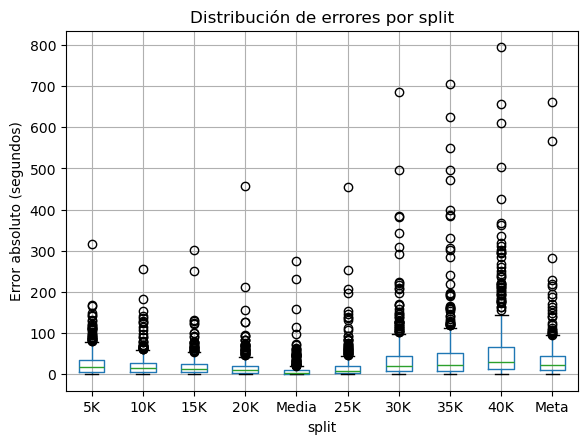

<Figure size 600x500 with 0 Axes>

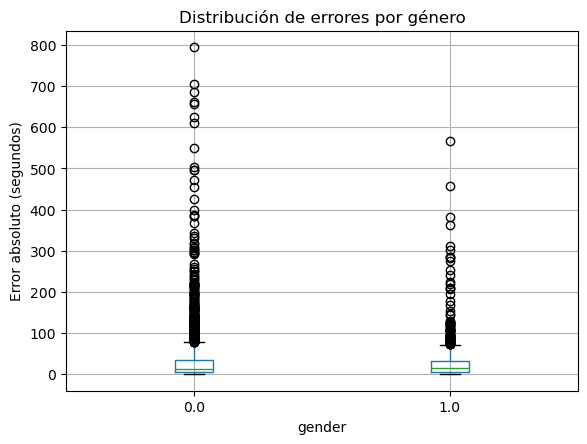

<Figure size 800x500 with 0 Axes>

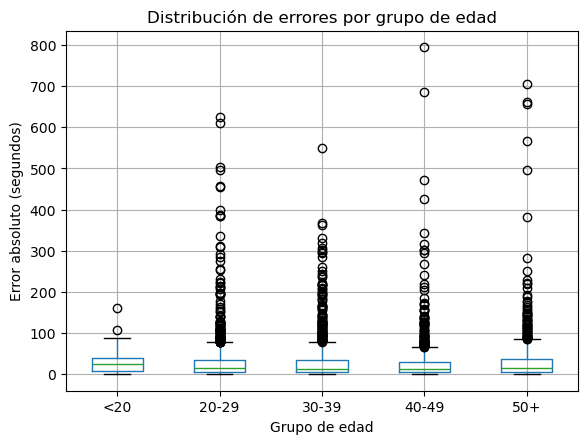

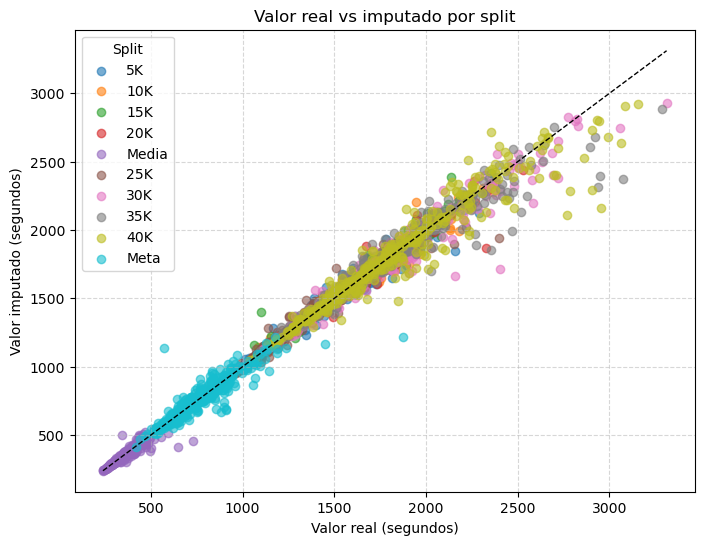

In [32]:
df_wide = preparar_datos_maraton(athletes_events_df, athletes_time_df, athletes_df,
                                                             race_id_filter='49603c2f-1b2b-457f-b82e-fed8bded1d3d',
                                                             event_std_filter='maraton')

df_imputed_sec, comparison, mae_per_split, mae_overall, df_wide = imputacion_knn(df_wide, split_cols,
                                                                                             nan_fraction=0.2)

In [33]:
df_imputed_sec.head(5)

athlete_id                               race_id  \
0  01eca658-9206-509d-b977-10aa8c33dcb9  49603c2f-1b2b-457f-b82e-fed8bded1d3d   
1  042a4b4e-6e1c-5896-9173-b0fc7963d82c  49603c2f-1b2b-457f-b82e-fed8bded1d3d   
2  04a810fd-4cd3-5521-9ebb-bb50c3897b6e  49603c2f-1b2b-457f-b82e-fed8bded1d3d   
3  05b1654f-a583-5e81-a92b-78fa6637f114  49603c2f-1b2b-457f-b82e-fed8bded1d3d   
4  10c487b4-1cd7-519c-8521-602bd48ed08d  49603c2f-1b2b-457f-b82e-fed8bded1d3d   

  event_id        5K       10K       15K       20K    Media       25K  \
0   Marato  1946.076  2157.272  2184.206  2001.858  594.604  1798.400   
1   Marato  1552.853  1580.306  1565.930  1555.900  349.867  1241.632   
2   Marato  1443.249  1472.570  1523.032  1567.877  377.513  1372.686   
3   Marato  1020.527  1015.678  1019.456  1011.072  224.714   791.899   
4   Marato  1304.114  1274.451  1292.676  1276.789  278.957   998.969   

        30K       35K       40K     Meta  gender        age  
0  2398.527  3347.550  3573.921  960.082     1.0  32.917180  
1  1636.204  1653.280  1749.712  796.298     0.0  26.913073  
2  2224.020  2171.176  2343.507  985.099     0.0  46.190281  
3  1017.761  1011.987   993.659  425.156     1.0  21.149897  
4  1258.380  1264.870  1246.995  522.230     1.0  37.500342

In [34]:
comparison.head(5)

athlete_id split  valor_real  valor_imputado  abs_error  gender        age  \
0   11CBCF6A    5K    1566.776     1560.737093   6.038907     0.0  48.793977   
1   125D4FF2    5K    1266.559     1284.862288  18.303288     0.0  39.488022   
2   12C4D383    5K    1030.238     1037.617490   7.379490     0.0  35.638604   
3   1385ZA13    5K    1445.522     1500.438592  54.916592     0.0  27.446954   
4   13C211CC    5K    1187.919     1201.796080  13.877080     0.0  40.514716   

  age_group  
0     40-49  
1     30-39  
2     30-39  
3     20-29  
4     40-49

In [35]:
df_wide.head(5)

athlete_id                               race_id  \
0  01eca658-9206-509d-b977-10aa8c33dcb9  49603c2f-1b2b-457f-b82e-fed8bded1d3d   
1  042a4b4e-6e1c-5896-9173-b0fc7963d82c  49603c2f-1b2b-457f-b82e-fed8bded1d3d   
2  04a810fd-4cd3-5521-9ebb-bb50c3897b6e  49603c2f-1b2b-457f-b82e-fed8bded1d3d   
3  05b1654f-a583-5e81-a92b-78fa6637f114  49603c2f-1b2b-457f-b82e-fed8bded1d3d   
4  10c487b4-1cd7-519c-8521-602bd48ed08d  49603c2f-1b2b-457f-b82e-fed8bded1d3d   

  event_id        5K       10K       15K       20K    Media       25K  \
0   Marato  1946.076  2157.272  2184.206  2001.858  594.604  1798.400   
1   Marato  1552.853  1580.306  1565.930  1555.900  349.867  1241.632   
2   Marato  1443.249  1472.570  1523.032  1567.877  377.513  1372.686   
3   Marato  1020.527  1015.678  1019.456  1011.072  224.714   791.899   
4   Marato  1304.114  1274.451  1292.676  1276.789  278.957   998.969   

        30K       35K       40K     Meta  gender        age  
0  2398.527  3347.550  3573.921  960.082     1.0  32.917180  
1  1636.204  1653.280  1749.712  796.298     0.0  26.913073  
2  2224.020  2171.176  2343.507  985.099     0.0  46.190281  
3  1017.761  1011.987   993.659  425.156     1.0  21.149897  
4  1258.380  1264.870  1246.995  522.230     1.0  37.500342

#### EDA y explicacion datos sencilla

Para hacer el estudio tendremos varios dfs que usaremos en dstintos contextos. Todos parten de df_wide, que es el df resultado de distribui los splits en columnas, junto a otra columnas identificativas como gender, age. tiempo acumulado en meta o los ids del atleta. Se hace así para poder distribuir los datos de mejor forma 

Número de muestras: 20653



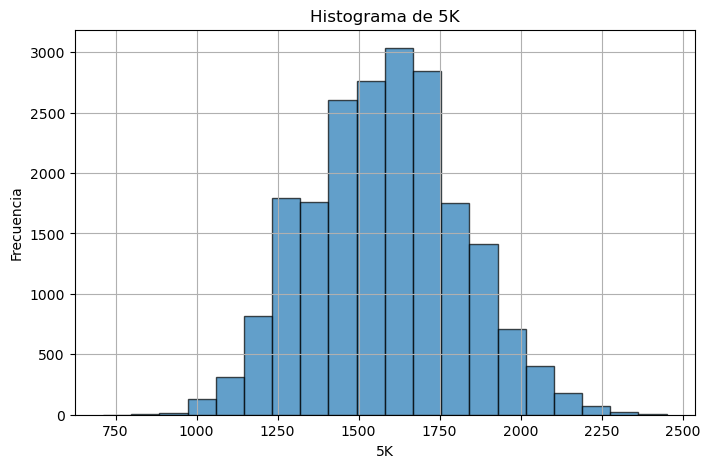

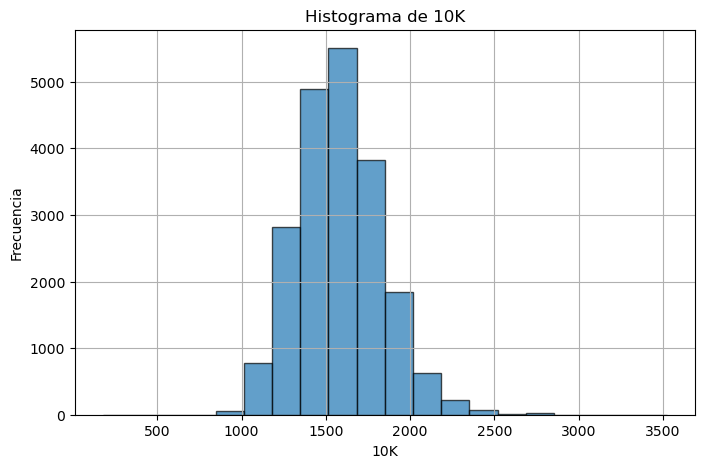

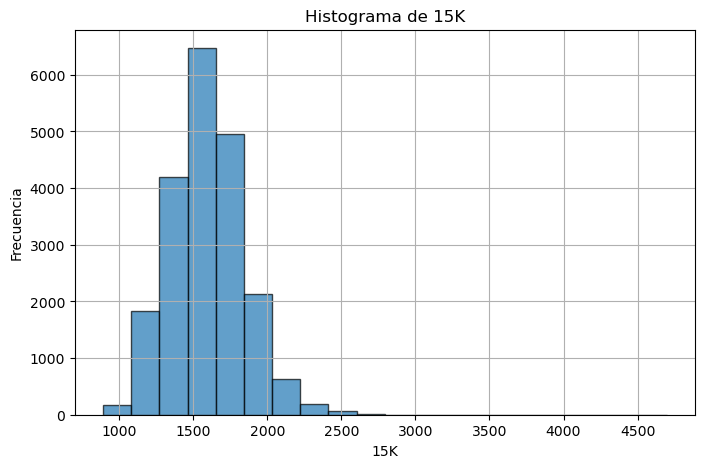

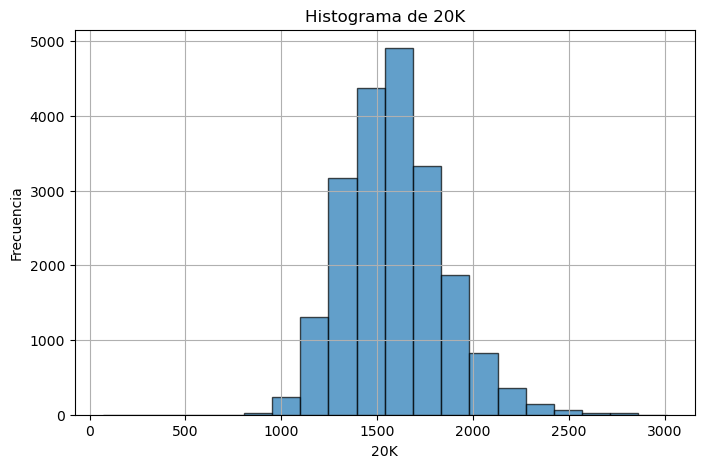

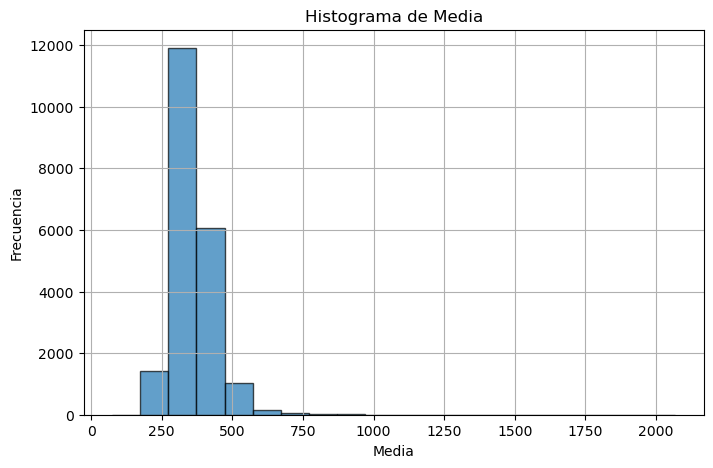

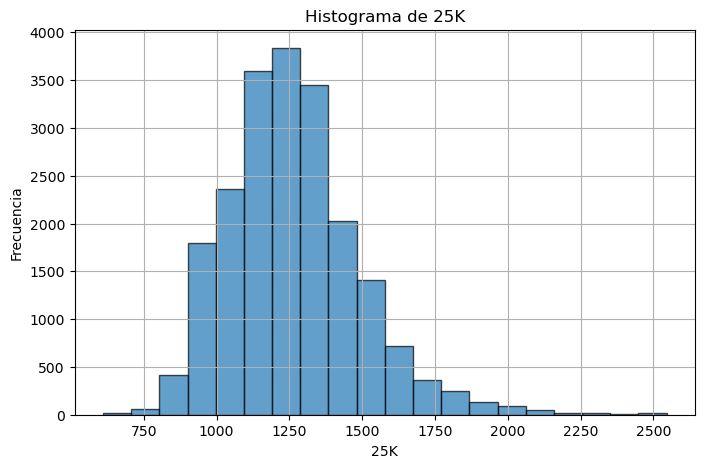

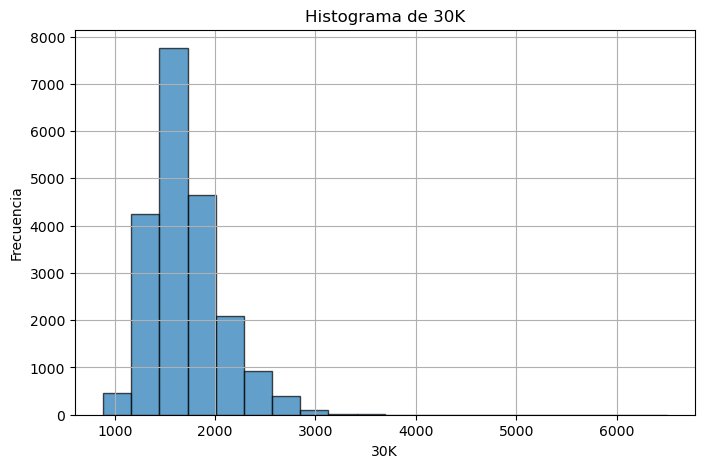

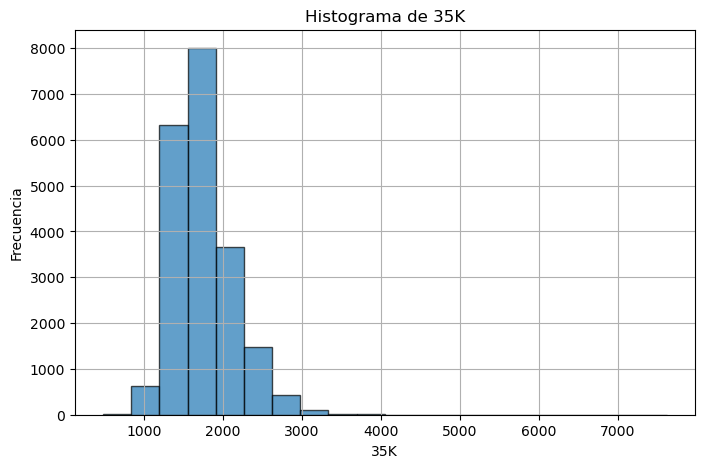

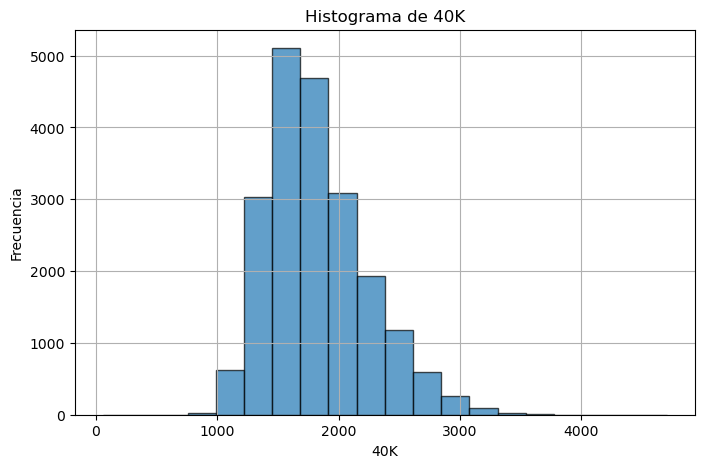

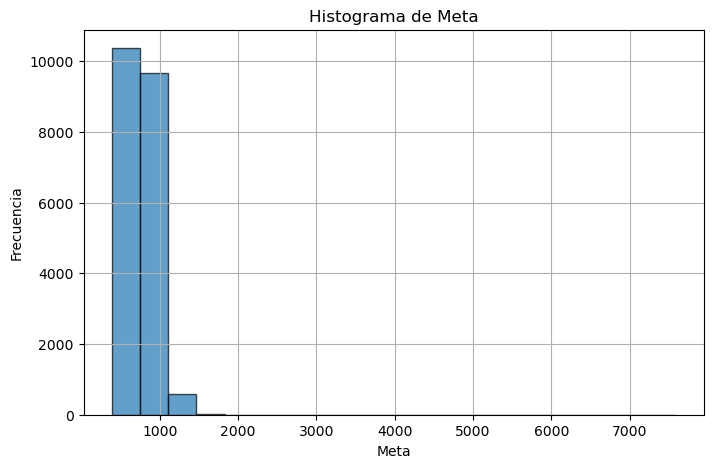

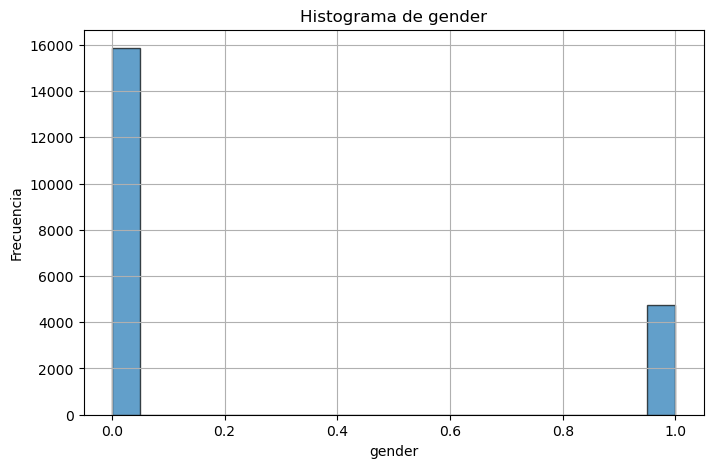

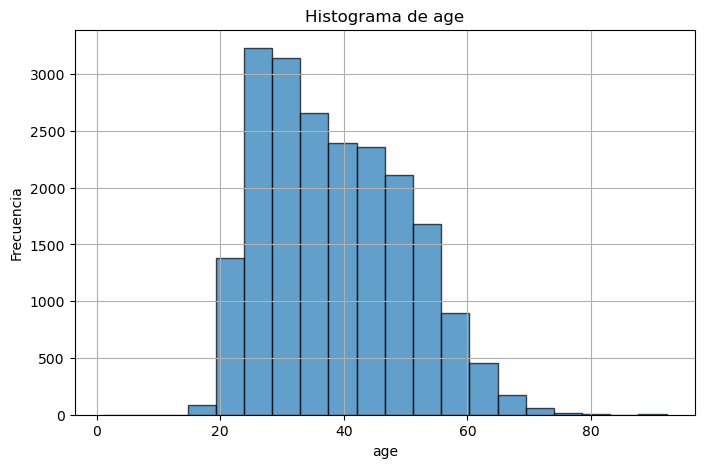

In [36]:
import matplotlib.pyplot as plt
import pandas as pd

def resumen_columnas(df, bins=20, figsize=(8,5)):
    """
    Muestra histogramas para variables continuas y gráficos de barras para discretas/categóricas,
    ignorando columnas que terminen en '_id'.

    Parámetros
    ----------
    df : DataFrame
        DataFrame a analizar.
    bins : int, opcional
        Número de bins para los histogramas de variables continuas.
    figsize : tuple, opcional
        Tamaño de las figuras.
    """
    columnas_filtradas = [col for col in df.columns if not col.endswith("_id")]

    continuas = df[columnas_filtradas].select_dtypes(include=['float64', 'float32']).columns
    discretas = df[columnas_filtradas].select_dtypes(include=['int64', 'int32', 'object', 'category']).columns

    print(f"Número de muestras: {len(df)}\n")
    
    for col in continuas:
        plt.figure(figsize=figsize)
        plt.hist(df[col], bins=bins, edgecolor='k', alpha=0.7)
        plt.xlabel(col)
        plt.ylabel("Frecuencia")
        plt.title(f"Histograma de {col}")
        plt.grid(True)
        plt.show()
    
    for col in discretas:
        plt.figure(figsize=figsize)
        df[col].value_counts().plot(kind='bar', edgecolor='k', alpha=0.7)
        plt.xlabel(col)
        plt.ylabel("Frecuencia")
        plt.title(f"Gráfico de barras de {col}")
        plt.grid(True, axis='y')
        plt.show()

resumen_columnas(df_wide)

Otros de los dfs usados son: 

- df_imputed_sec: Tiene la misma forma de df_wide, pero ya tiene los valores imputaos por KNN
- comparison: dataframe que compara valores reales vs imputados, con columnas como el valor real vs imputado o el error absoluto.

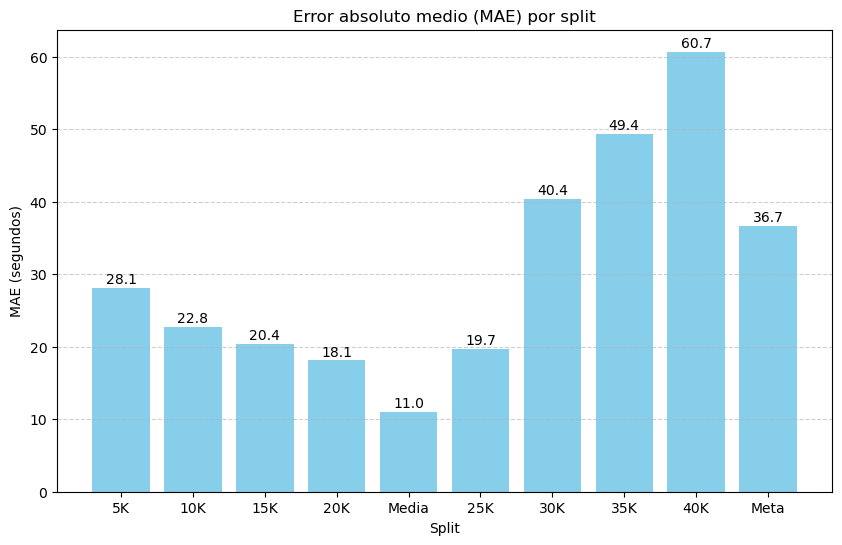

In [37]:
splits_ordered = [s for s in split_cols if s in mae_per_split]
mae_values_ordered = [mae_per_split[s] for s in splits_ordered]

plt.figure(figsize=(10,6))
plt.bar(splits_ordered, mae_values_ordered, color='skyblue')
plt.xlabel('Split')
plt.ylabel('MAE (segundos)')
plt.title('Error absoluto medio (MAE) por split')
plt.grid(axis='y', linestyle='--', alpha=0.6)

for i, v in enumerate(mae_values_ordered):
    plt.text(i, v + 0.2, f"{v:.1f}", ha='center', va='bottom')

plt.show()

#### Creación de columnas de error
- Se generan columnas binarias que indican si el error relativo de la imputación supera ciertos umbrales respecto al valor real (valor_real): 10%, 25%, 50% y 100%.

#### Cálculo de z-score por split
- Para cada split, se calcula la media y desviación estándar entre todos los atletas.
- Se genera un dataframe (df_comparacion) con:
  - Valor real del split.
  - Media y desviación del split entre otros atletas.
  - Z-score del split respecto al promedio del grupo, indicando cuán “atípico” es el desempeño de un atleta en ese split.

#### Distancias y vecinos cercanos
- Se calcula la matriz de distancias euclidianas considerando NaN (nan_euclidean_distances) sobre df_features.
- Se define un umbral (0.5) para identificar vecinos cercanos y se cuenta cuántos atletas están dentro de esa distancia para cada atleta.
- Esta información se agrega a df_comparacion como num_vecinos_cercanos, proporcionando contexto sobre similitud entre atletas.

#### Merge de información adicional
- Se agrega nuevamente la información de edad y género a df_comparacion para tener un dataframe completo con métricas de desempeño, similitud entre atletas y datos demográficos.

#### Filtrado de splits según error
- df_mal: contiene splits donde el error absoluto supera el 10%, considerados “mal imputados”.
- df_bien: contiene splits imputados con error ≤10%, considerados “bien imputados”.
- Ambos dataframes sirven para análisis posteriores de calidad de imputación y comportamiento de los splits.

#### Salida de la función
- df_mal: splits con imputación defectuosa.
- df_bien: splits con imputación aceptable.
- df_comparacion: información completa de splits, número de vecinos cercanos, edad y género de cada atleta.
- df_splits: dataframe en formato “wide” con cada fila por atleta y cada columna por split (valores reales).
- df_features: dataframe que combina los splits en formato wide con información de edad y género. 

In [63]:
from sklearn.metrics.pairwise import nan_euclidean_distances
import pandas as pd

def analisis_mal_imputado(df_wide, comparison):
    """
    Analiza splits imputados y genera:
    - df_mal: splits con error >10%
    - df_bien: splits imputados con error ≤10%
    - df_comparacion: información completa de splits, z-score, vecinos, edad/género
    """
    df = comparison.copy()
    
    umbrales = [0.1, 0.25, 0.5, 1.0] 
    for u in umbrales:
        col_name = f'error_mayor_{int(u*100)}%'
        df[col_name] = df['abs_error'] > (u * df['valor_real'])
    
    df_splits = df.pivot_table(index='athlete_id', columns='split', values='valor_real')
    
    atletas_info = df.groupby('athlete_id')[['age','gender']].first()
    df_features = pd.concat([df_splits, atletas_info], axis=1)
    
    df_comparacion = []
    for split in df_splits.columns:
        mean_split = df_splits[split].mean()
        std_split = df_splits[split].std()
        temp = pd.DataFrame({
            'athlete_id': df_splits.index,
            'split': split,
            'valor_real': df_splits[split],
            'mean_split_otros': mean_split,
            'std_split_otros': std_split,
        })
        df_comparacion.append(temp)
    
    df_comparacion = pd.concat(df_comparacion, ignore_index=True)
    
    dist_matrix = nan_euclidean_distances(df_features)
    dist_df = pd.DataFrame(dist_matrix, index=df_features.index, columns=df_features.index)
    threshold = 0.5
    vecinos_cercanos = (dist_df < threshold).sum(axis=1) - 1
    df_comparacion = df_comparacion.merge(vecinos_cercanos.rename('num_vecinos_cercanos'), on='athlete_id', how='left')
    
    df_comparacion = df_comparacion.merge(atletas_info, left_on='athlete_id', right_index=True, how='left')
    df_mal = df[df['error_mayor_10%']].copy()
    df_bien = df[(~df['error_mayor_10%']) & (df['abs_error'] > 0)].copy()
    
    return df_mal, df_bien, df_comparacion, df_splits, df_features

In [64]:
df_mal, df_bien, df_comparacion, df_splits, df_features = analisis_mal_imputado(df_wide, comparison)

C:\Users\mario\AppData\Local\Temp\ipykernel_12360\2629461495.py:18: FutureWarning:

The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior



In [40]:
df_mal.head(5)

athlete_id split  valor_real  valor_imputado   abs_error  gender  \
6      14D4DD79    5K    1163.497     1281.130074  117.633074     0.0   
132    5Z49Y8DY    5K    2159.240     1843.829514  315.410486     0.0   
750    F68DA5A7   10K    1945.415     2202.182975  256.767975     0.0   
846    1D8965C2   15K    2136.898     2387.015507  250.117507     0.0   
1112   C279DB3C   15K    1099.138     1401.662560  302.524560     0.0   

            age age_group  error_mayor_10%  error_mayor_25%  error_mayor_50%  \
6     31.876797     30-39             True            False            False   
132   43.260780     40-49             True            False            False   
750   22.981520     20-29             True            False            False   
846   62.650240       50+             True            False            False   
1112  43.838467     40-49             True             True            False   

      error_mayor_100%  
6                False  
132              False  
750              False  
846              False  
1112             False

In [41]:
df_bien.head(5)

athlete_id split  valor_real  valor_imputado  abs_error  gender        age  \
0   11CBCF6A    5K    1566.776     1560.737093   6.038907     0.0  48.793977   
1   125D4FF2    5K    1266.559     1284.862288  18.303288     0.0  39.488022   
2   12C4D383    5K    1030.238     1037.617490   7.379490     0.0  35.638604   
3   1385ZA13    5K    1445.522     1500.438592  54.916592     0.0  27.446954   
4   13C211CC    5K    1187.919     1201.796080  13.877080     0.0  40.514716   

  age_group  error_mayor_10%  error_mayor_25%  error_mayor_50%  \
0     40-49            False            False            False   
1     30-39            False            False            False   
2     30-39            False            False            False   
3     20-29            False            False            False   
4     40-49            False            False            False   

   error_mayor_100%  
0             False  
1             False  
2             False  
3             False  
4             False

In [65]:
df_comparacion.head(5)

athlete_id split  valor_real  mean_split_otros  std_split_otros  \
0   11271FAB    5K         NaN       1574.149234       232.907354   
1   113BA64Z    5K         NaN       1574.149234       232.907354   
2   113F8448    5K         NaN       1574.149234       232.907354   
3  114500005    5K         NaN       1574.149234       232.907354   
4   1152C877    5K         NaN       1574.149234       232.907354   

   num_vecinos_cercanos        age  gender  
0                    47  26.513347     0.0  
1                    27  36.136893     0.0  
2                    59  27.890486     0.0  
3                    43  30.340862     0.0  
4                    19  29.059548     1.0

In [43]:
df_splits.head(5)

split       5K       10K  15K       20K    Media  25K       30K  35K  40K  \
athlete_id                                                                  
11271FAB   NaN       NaN  NaN  1389.807      NaN  NaN       NaN  NaN  NaN   
113BA64Z   NaN       NaN  NaN       NaN  309.205  NaN       NaN  NaN  NaN   
113F8448   NaN  1320.684  NaN       NaN      NaN  NaN       NaN  NaN  NaN   
114500005  NaN       NaN  NaN       NaN      NaN  NaN       NaN  NaN  NaN   
1152C877   NaN       NaN  NaN       NaN      NaN  NaN  1566.706  NaN  NaN   

split          Meta  
athlete_id           
11271FAB        NaN  
113BA64Z        NaN  
113F8448        NaN  
114500005   441.519  
1152C877        NaN

In [44]:
df_features.head(5)

5K       10K  15K       20K    Media  25K       30K  35K  40K  \
athlete_id                                                                  
11271FAB   NaN       NaN  NaN  1389.807      NaN  NaN       NaN  NaN  NaN   
113BA64Z   NaN       NaN  NaN       NaN  309.205  NaN       NaN  NaN  NaN   
113F8448   NaN  1320.684  NaN       NaN      NaN  NaN       NaN  NaN  NaN   
114500005  NaN       NaN  NaN       NaN      NaN  NaN       NaN  NaN  NaN   
1152C877   NaN       NaN  NaN       NaN      NaN  NaN  1566.706  NaN  NaN   

               Meta        age  gender  
athlete_id                              
11271FAB        NaN  26.513347     0.0  
113BA64Z        NaN  36.136893     0.0  
113F8448        NaN  27.890486     0.0  
114500005   441.519  30.340862     0.0  
1152C877        NaN  29.059548     1.0

In [45]:
df_imputados = pd.concat([df_mal, df_bien], ignore_index=True)

In [46]:
df_imputados['MAE_relativo'] = np.abs(df_imputados['valor_real'] - df_imputados['valor_imputado']) / df_imputados['valor_real']

In [47]:
df_imputados.head(5)

athlete_id split  valor_real  valor_imputado   abs_error  gender        age  \
0   14D4DD79    5K    1163.497     1281.130074  117.633074     0.0  31.876797   
1   5Z49Y8DY    5K    2159.240     1843.829514  315.410486     0.0  43.260780   
2   F68DA5A7   10K    1945.415     2202.182975  256.767975     0.0  22.981520   
3   1D8965C2   15K    2136.898     2387.015507  250.117507     0.0  62.650240   
4   C279DB3C   15K    1099.138     1401.662560  302.524560     0.0  43.838467   

  age_group  error_mayor_10%  error_mayor_25%  error_mayor_50%  \
0     30-39             True            False            False   
1     40-49             True            False            False   
2     20-29             True            False            False   
3       50+             True            False            False   
4     40-49             True             True            False   

   error_mayor_100%  MAE_relativo  
0             False      0.101103  
1             False      0.146075  
2             False      0.131986  
3             False      0.117047  
4             False      0.275238

In [48]:
mae_por_split = df_imputados.groupby('split')['MAE_relativo'].mean().reset_index()

C:\Users\mario\AppData\Local\Temp\ipykernel_12360\5504127.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mae_por_split = df_imputados.groupby('split')['MAE_relativo'].mean().reset_index()


In [49]:
df_wide.head(5)

athlete_id                               race_id  \
0  01eca658-9206-509d-b977-10aa8c33dcb9  49603c2f-1b2b-457f-b82e-fed8bded1d3d   
1  042a4b4e-6e1c-5896-9173-b0fc7963d82c  49603c2f-1b2b-457f-b82e-fed8bded1d3d   
2  04a810fd-4cd3-5521-9ebb-bb50c3897b6e  49603c2f-1b2b-457f-b82e-fed8bded1d3d   
3  05b1654f-a583-5e81-a92b-78fa6637f114  49603c2f-1b2b-457f-b82e-fed8bded1d3d   
4  10c487b4-1cd7-519c-8521-602bd48ed08d  49603c2f-1b2b-457f-b82e-fed8bded1d3d   

  event_id        5K       10K       15K       20K    Media       25K  \
0   Marato  1946.076  2157.272  2184.206  2001.858  594.604  1798.400   
1   Marato  1552.853  1580.306  1565.930  1555.900  349.867  1241.632   
2   Marato  1443.249  1472.570  1523.032  1567.877  377.513  1372.686   
3   Marato  1020.527  1015.678  1019.456  1011.072  224.714   791.899   
4   Marato  1304.114  1274.451  1292.676  1276.789  278.957   998.969   

        30K       35K       40K     Meta  gender        age  
0  2398.527  3347.550  3573.921  960.082     1.0  32.917180  
1  1636.204  1653.280  1749.712  796.298     0.0  26.913073  
2  2224.020  2171.176  2343.507  985.099     0.0  46.190281  
3  1017.761  1011.987   993.659  425.156     1.0  21.149897  
4  1258.380  1264.870  1246.995  522.230     1.0  37.500342

In [50]:
import matplotlib.pyplot as plt

def graficos_variabilidad_split(mae_por_split, df_wide, split_cols=['5K','10K','15K','20K','Meta']):
    """
    Genera gráficos por split: MAE relativo, desviación estándar y coeficiente de variación (CV).
    
    Parámetros:
    - mae_por_split: dataframe con columnas ['split', 'MAE_relativo']
    - df_wide: dataframe con tiempos absolutos por split
    - split_cols: lista con el orden de los splits
    """
    std_por_split = df_wide[split_cols].std().reset_index()
    std_por_split.columns = ['split', 'std_split']

    cv_por_split = (df_wide[split_cols].std() / df_wide[split_cols].mean()).reset_index()
    cv_por_split.columns = ['split', 'CV_split']

    fig, axes = plt.subplots(3, 1, figsize=(10, 15))

    axes[0].bar(mae_por_split['split'], mae_por_split['MAE_relativo'], color='skyblue')
    axes[0].set_ylabel('MAE relativo promedio')
    axes[0].set_title('MAE relativo por split')
    axes[0].grid(axis='y', linestyle='--', alpha=0.6)

    axes[1].bar(std_por_split['split'], std_por_split['std_split'], color='orange')
    axes[1].set_ylabel('Desviación estándar (segundos)')
    axes[1].set_title('Variabilidad de tiempo por split')
    axes[1].grid(axis='y', linestyle='--', alpha=0.6)

    axes[2].bar(cv_por_split['split'], cv_por_split['CV_split'], color='green')
    axes[2].set_ylabel('CV de tiempo por split')
    axes[2].set_xlabel('Split')
    axes[2].set_title('Variabilidad relativa (CV) por split')
    axes[2].grid(axis='y', linestyle='--', alpha=0.6)

    plt.tight_layout()
    plt.show()

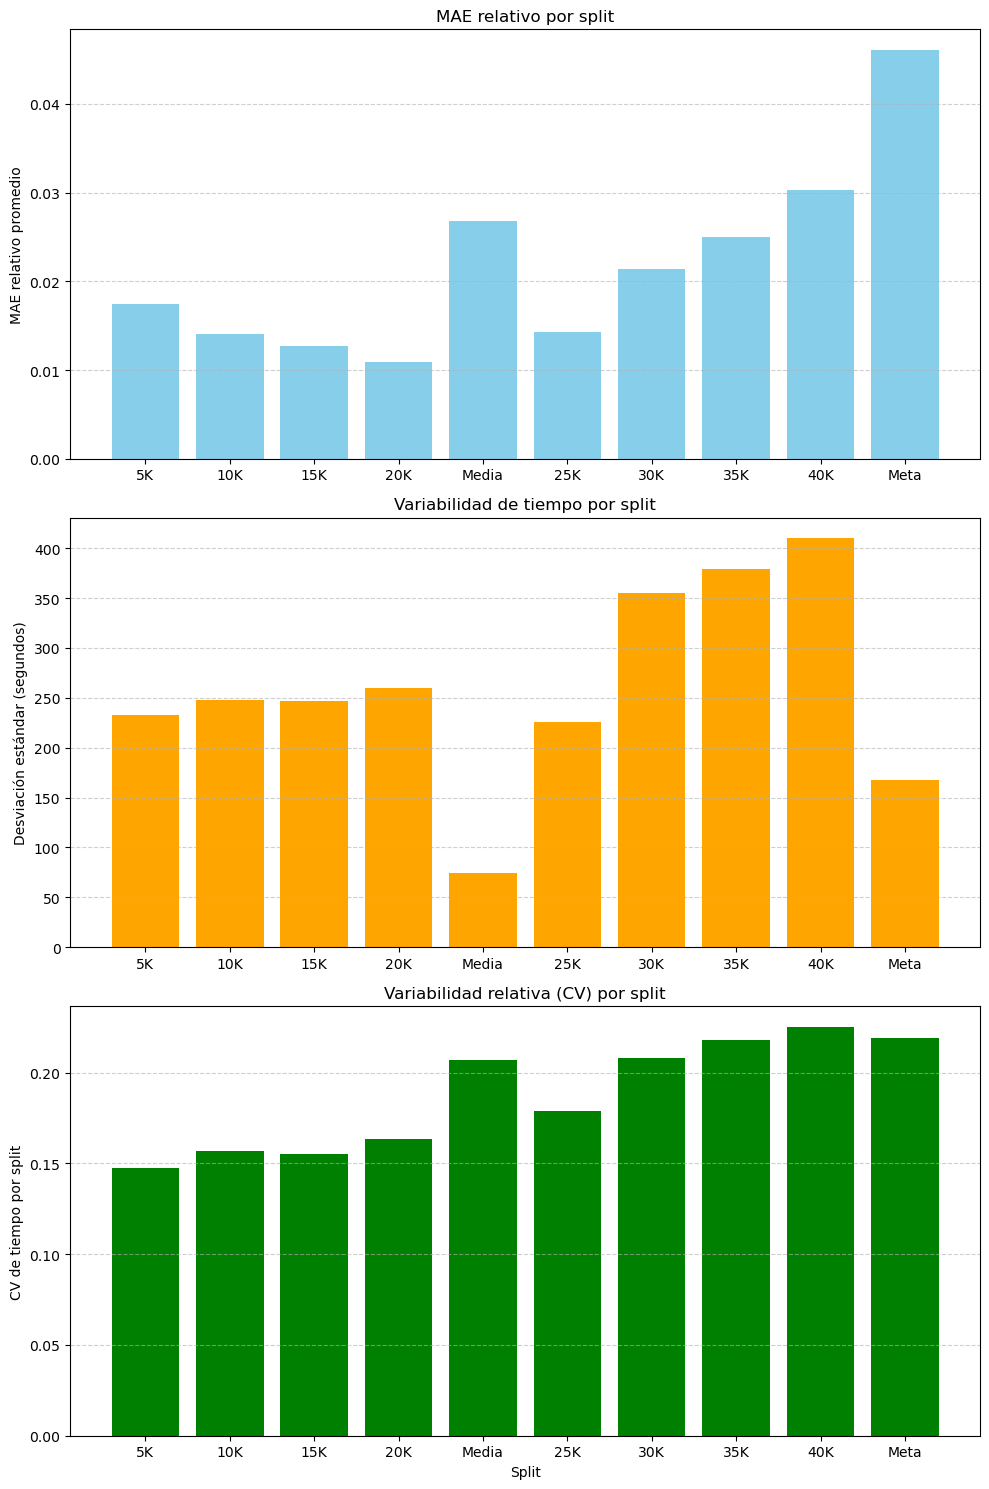

In [51]:
graficos_variabilidad_split(mae_por_split, df_wide, split_cols)

Contamos el número de atletas en cada grupo

In [52]:
def resumen_grupos_error(df_mal):
    """
    Calcula y muestra el número de atletas en diferentes grupos de error.
    
    Grupos considerados:
    - ≥10%
    - ≥25%
    - ≥50%
    - ≥100%
    
    Parámetros:
    - df_mal: dataframe que contiene las columnas:
        'error_mayor_10%', 'error_mayor_25%', 'error_mayor_50%', 'error_mayor_100%'
        y 'athlete_id'
    """
    grupos_mal = {
        '≥10%': df_mal[df_mal['error_mayor_10%']]['athlete_id'].unique(),
        '≥25%': df_mal[df_mal['error_mayor_25%']]['athlete_id'].unique(),
        '≥50%': df_mal[df_mal['error_mayor_50%']]['athlete_id'].unique(),
        '≥100%': df_mal[df_mal['error_mayor_100%']]['athlete_id'].unique()
    }

    for grupo, atletas in grupos_mal.items():
        n_atletas = len(atletas)
        print(f'Grupo {grupo}: {n_atletas} atletas')

In [53]:
resumen_grupos_error(df_mal)

Grupo ≥10%: 120 atletas
Grupo ≥25%: 9 atletas
Grupo ≥50%: 1 atletas
Grupo ≥100%: 0 atletas


#### Selección de columnas de splits
- Se identifican las columnas correspondientes a los splits, excluyendo columnas de identificación y demográficas.
- Esto asegura que solo se grafican los tiempos por split.

#### Definición de grupos
- Se crean los grupos de atletas según el nivel de error de imputación:
  - '<10%': atletas bien imputados, que tiene menos del 10% de error relativo al valor real.
  - '≥10%', '≥25%', '≥50%', '≥100%': atletas mal imputados según su error.
  - 'No imputados': atletas sin ninguna imputación.

#### Muestra de referencia
- El tamaño del grupo se usa como referencia para seleccionar muestras aleatorias de los grupos '<10%' y 'No imputados'.
- Esto garantiza que las curvas comparativas tengan una cantidad similar de atletas y no se vean sesgadas por tamaños de grupo distintos.

In [54]:
comparison['fue_imputado'] = comparison['abs_error'] > 0

atletas_bien_imputados = comparison[(comparison['fue_imputado']) & 
                                    (comparison['abs_error'] <= 0.1 * comparison['valor_real'])]['athlete_id'].unique()

print("Número de atletas imputados con error ≤10%:", len(atletas_bien_imputados))

Número de atletas imputados con error ≤10%: 4007


In [55]:
todos_atletas = df_wide['athlete_id'].unique()
atletas_imputados = np.union1d(atletas_bien_imputados, df_mal['athlete_id'].unique())
atletas_no_imputados = np.setdiff1d(todos_atletas, atletas_imputados)

print("Número de atletas no imputados:", len(atletas_no_imputados))

Número de atletas no imputados: 16526


In [56]:
import matplotlib.pyplot as plt
import numpy as np

def graficar_curvas_error_imputacion(df_wide, df_mal, atletas_bien_imputados, atletas_no_imputados,
                                     figsize=(12,6), colores=None, random_state=42):
    """
    Grafica las curvas promedio de tiempos reales por grupo de error de imputación,
    incluyendo también una muestra de atletas no imputados.

    Parámetros:
    - df_wide: DataFrame con los tiempos reales por split (columnas de splits)
    - df_mal: DataFrame con los atletas mal imputados y sus errores
    - atletas_bien_imputados: lista o array con athlete_id de los bien imputados (<10%)
    - atletas_no_imputados: lista o array con athlete_id de atletas sin imputaciones
    - figsize: tupla con tamaño de la figura (default: (12,6))
    - colores: lista de colores para cada grupo (default: ['green','orange','red','purple','brown','blue'])
    - random_state: semilla para reproducibilidad
    """
    
    if colores is None:
        colores = ['green','orange','red','purple','brown','blue']
    
    splits_cols = [c for c in df_wide.columns if c not in ['athlete_id','race_id','event_id','gender','age']]
    
    grupos = {
        '<10%': atletas_bien_imputados,
        '≥10%': df_mal[df_mal['error_mayor_10%']]['athlete_id'].unique(),
        '≥25%': df_mal[df_mal['error_mayor_25%']]['athlete_id'].unique(),
        '≥50%': df_mal[df_mal['error_mayor_50%']]['athlete_id'].unique(),
        '≥100%': df_mal[df_mal['error_mayor_100%']]['athlete_id'].unique(),
        'No imputados': atletas_no_imputados
    }
    
    n_muestra_ref = len(grupos['≥10%'])
    
    plt.figure(figsize=figsize)
    
    for i, (grupo, atletas) in enumerate(grupos.items()):
        if len(atletas) == 0:
            continue
        
        if grupo in ['<10%', 'No imputados']:
            n_muestra = min(n_muestra_ref, len(atletas))
            np.random.seed(random_state)
            atletas = np.random.choice(atletas, size=n_muestra, replace=False)
        
        curvas = df_wide[df_wide['athlete_id'].isin(atletas)][splits_cols]
        
        if curvas.empty:
            continue
        
        curva_promedio = curvas.mean(axis=0)
        n_atletas = len(curvas)
        
        plt.plot(splits_cols, curva_promedio.values, color=colores[i], linewidth=2,
                 label=f'{grupo} (n={n_atletas})')
    
    plt.xlabel('Splits')
    plt.ylabel('Tiempo promedio (segundos)')
    plt.title('Curvas promedio de tiempos reales según error de imputación')
    plt.xticks(rotation=45)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.legend()
    plt.show()

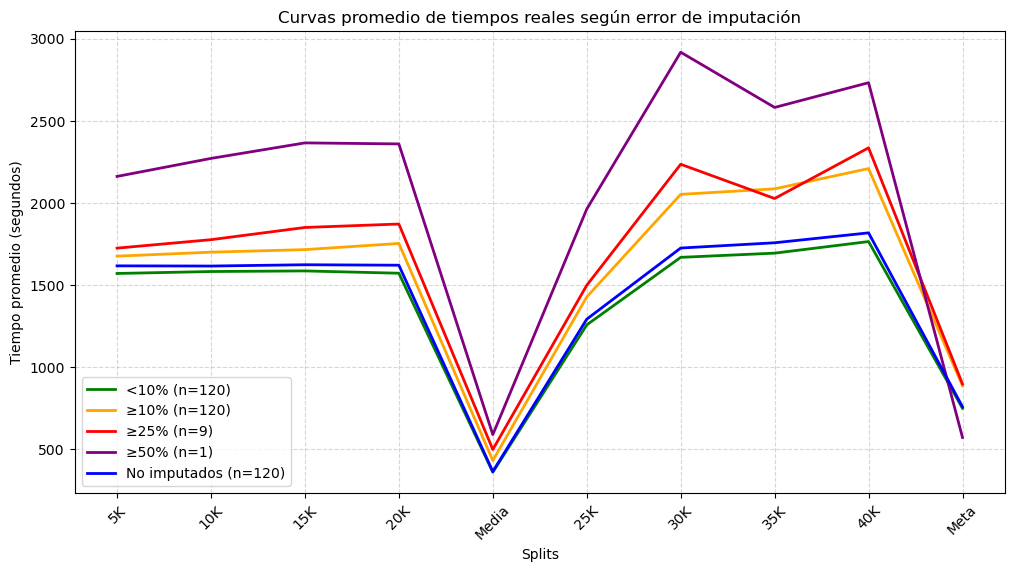

In [57]:
graficar_curvas_error_imputacion(df_wide, df_mal, atletas_bien_imputados, atletas_no_imputados)

Podemos observar también el valor por meta vs MAE absoluto

In [58]:
import pandas as pd
import numpy as np
import plotly.express as px


meta_times = (
    athletes_time_df[athletes_time_df["split"] == "Meta"]
    .loc[:, ["athlete_id", "netTime"]]
    .drop_duplicates()
)

mae_por_atleta = (
    df_imputados.groupby("athlete_id")["abs_error"]
    .mean()
    .reset_index()
    .rename(columns={"abs_error": "MAE"})
)

df_base = mae_por_atleta.merge(meta_times, on="athlete_id", how="inner")
df_base["netTime_s"] = df_base["netTime"] / 1000  

grupos = {
    '<10%': atletas_bien_imputados,
    '≥10%': df_mal[df_mal['error_mayor_10%']]['athlete_id'].unique(),
    '≥25%': df_mal[df_mal['error_mayor_25%']]['athlete_id'].unique(),
    '≥50%': df_mal[df_mal['error_mayor_50%']]['athlete_id'].unique(),
    '≥100%': df_mal[df_mal['error_mayor_100%']]['athlete_id'].unique()
}

plot_data = []
for label, athletes in grupos.items():
    df_g = df_base[df_base["athlete_id"].isin(athletes)].copy()
    df_g['grupo'] = label
    plot_data.append(df_g)

df_plot = pd.concat(plot_data, ignore_index=True)


fig = px.scatter(
    df_plot,
    x='netTime_s',
    y='MAE',
    color='grupo',            
    symbol='grupo',           
    hover_data=['athlete_id'],
    size_max=12
)

fig.update_layout(
    title="Relación MAE vs Tiempo Meta por grupos de error",
    xaxis_title="Tiempo en Meta (s)",
    yaxis_title="MAE (error medio absoluto)",
    legend_title="Grupo de error",
    template="plotly_white"
)

fig.show()

In [59]:
import pandas as pd
import numpy as np
import plotly.express as px

def graficar_mae_3d(df_wide, df_imputados, df_mal, df_bien, split_cols):
    """
    Genera un gráfico 3D interactivo de MAE relativo por atleta frente al promedio y CV de sus splits.
    
    Parámetros:
    - df_wide: DataFrame con los splits por atleta (cada split como columna)
    - df_imputados: DataFrame con columnas ['athlete_id', 'split', 'MAE_relativo']
    - df_mal: DataFrame de atletas con errores grandes
    - df_bien: DataFrame de atletas con errores pequeños
    - split_cols: lista de nombres de columnas de splits a considerar para promedio y CV
    """
    
    atletas_mal = df_mal['athlete_id'].unique()
    atletas_bien = df_bien['athlete_id'].unique()
    
    atletas_imputados = np.union1d(atletas_mal, atletas_bien)
    
    mae_per_athlete = (
        df_imputados.groupby('athlete_id')['MAE_relativo']
        .mean()
        .reset_index()
        .rename(columns={'MAE_relativo':'MAE'})
    )
    
    df_analysis = df_wide[df_wide['athlete_id'].isin(atletas_imputados)].copy()
    
    df_analysis['mean_split'] = df_analysis[split_cols].mean(axis=1)
    df_analysis['CV_split'] = df_analysis[split_cols].std(axis=1) / df_analysis['mean_split']
    
    df_analysis = df_analysis.merge(mae_per_athlete, on='athlete_id', how='left')
    
    fig = px.scatter_3d(
        df_analysis,
        x='mean_split',
        y='CV_split',
        z='MAE',
        color='MAE',
        hover_data=['athlete_id'] + split_cols,
        size_max=8
    )
    
    fig.update_layout(
        scene=dict(
            xaxis_title='Promedio de splits (s)',
            yaxis_title='CV de splits',
            zaxis_title='MAE relativo'
        ),
        title='MAE vs Promedio y CV de splits (interactivo)'
    )
    
    fig.show()

In [60]:
graficar_mae_3d(df_wide, df_imputados, df_mal, df_bien, split_cols)

In [61]:
def analizar_mejores_atletas(df_wide, df_mal, atletas_bien_imputados):
    """
    Analiza a los mejores atletas según tiempo promedio de splits y su relación con los errores de imputación.
    
    Args:
    - df_wide: DataFrame con tiempos de splits por atleta (cada split en columna)
    - df_mal: DataFrame con errores de imputación por split
    - atletas_bien_imputados: lista o array de IDs de atletas bien imputados
    
    Retorna:
    - conteo_mejores: diccionario con número de mejores atletas por grupo de error
    - mejor_atleta_id: ID del atleta imputado más rápido
    - mejor_atleta_tiempo: tiempo total del atleta más rápido
    - errores_mejor_atleta: DataFrame con errores de imputación del atleta más rápido
    """
    
    split_cols = [c for c in df_wide.columns if c not in ['athlete_id','race_id','event_id','gender','age']]
    promedio_real = df_wide.set_index('athlete_id')[split_cols].mean(axis=1)
    
    mejores_200 = promedio_real.nsmallest(200)
    mejores_ids = mejores_200.index
    
    grupos_error = {
        '<10%': set(atletas_bien_imputados),
        '≥10%': set(df_mal[df_mal['error_mayor_10%']]['athlete_id'].unique()),
        '≥25%': set(df_mal[df_mal['error_mayor_25%']]['athlete_id'].unique()),
        '≥50%': set(df_mal[df_mal['error_mayor_50%']]['athlete_id'].unique()),
        '≥100%': set(df_mal[df_mal['error_mayor_100%']]['athlete_id'].unique())
    }
    
    conteo_mejores = {}
    for grupo, atletas in grupos_error.items():
        conteo_mejores[grupo] = len(atletas.intersection(mejores_ids))
    
    tiempo_total = df_wide.set_index('athlete_id')[split_cols].sum(axis=1)
    
    atletas_imputados = df_mal['athlete_id'].unique()
    tiempo_total_imputados = tiempo_total.loc[tiempo_total.index.isin(atletas_imputados)]
    
    mejor_atleta_id = tiempo_total_imputados.idxmin()
    mejor_atleta_tiempo = tiempo_total_imputados.min()
    
    errores_mejor_atleta = df_mal[df_mal['athlete_id'] == mejor_atleta_id][
        ['split','valor_real','valor_imputado','abs_error']
    ]
    
    print(f"Atleta más rápido imputado: {mejor_atleta_id}")
    print(f"Tiempo total real: {mejor_atleta_tiempo:.2f} segundos")
    print("Errores de imputación por split:")
    print(errores_mejor_atleta)
    
    return conteo_mejores, mejor_atleta_id, mejor_atleta_tiempo, errores_mejor_atleta


In [62]:
conteo, atleta_id, tiempo, errores = analizar_mejores_atletas(df_wide, df_mal, atletas_bien_imputados)

Atleta más rápido imputado: 1CD9D8C7
Tiempo total real: 10660.08 segundos
Errores de imputación por split:
     split  valor_real  valor_imputado  abs_error
3741  Meta      655.15       576.00694   79.14306


### media

In [73]:
split_cols = ['5K', '10K', '15K', '20K', 'Meta']

INFO: Filtrando eventos completos y tipo de evento
INFO: Merge de tiempos y eventos
INFO: Filtrado por race_id=b228b93e-2a15-4123-baf9-ca0915165c6a, filas restantes: 158557
INFO: n_neighbors=5: MAE=28.74 seg
INFO: n_neighbors=10: MAE=27.71 seg
INFO: n_neighbors=15: MAE=27.55 seg
INFO: n_neighbors=20: MAE=27.52 seg
INFO: n_neighbors=25: MAE=27.46 seg
INFO: n_neighbors=30: MAE=27.47 seg
INFO: n_neighbors=50: MAE=27.65 seg
INFO: n_neighbors=100: MAE=28.23 seg
INFO: n_neighbors=200: MAE=29.14 seg
INFO: Mejor n_neighbors=25 con MAE=27.46 seg
C:\Users\mario\AppData\Local\Temp\ipykernel_12360\2497849520.py:124: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



<Figure size 800x500 with 0 Axes>

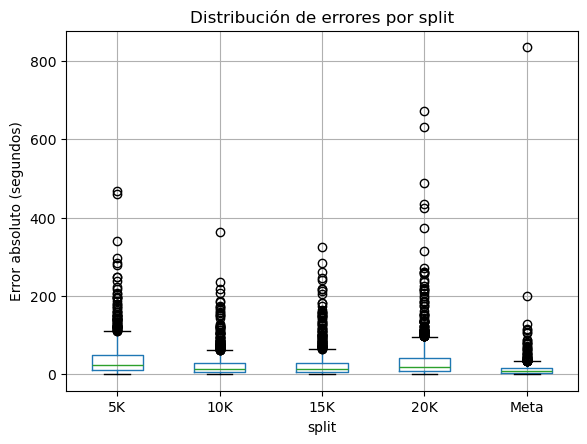

<Figure size 600x500 with 0 Axes>

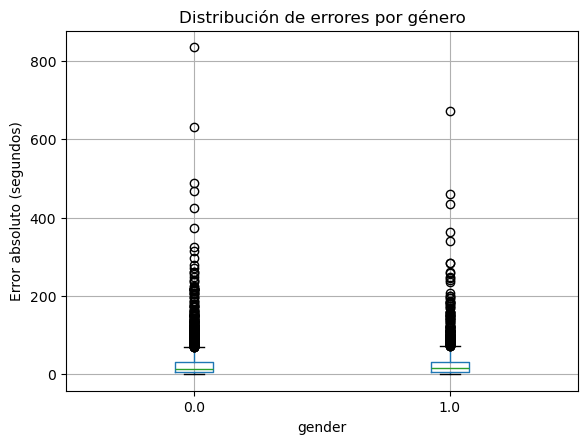

<Figure size 800x500 with 0 Axes>

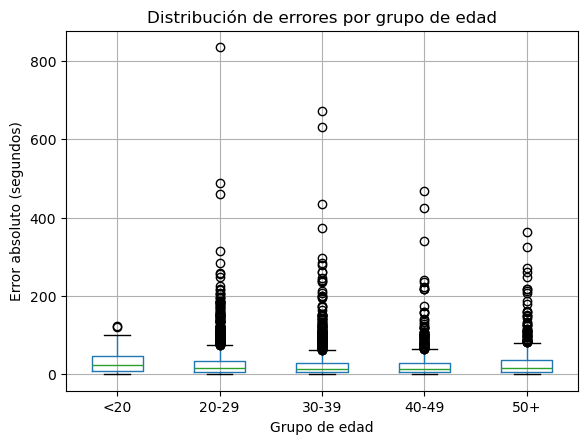

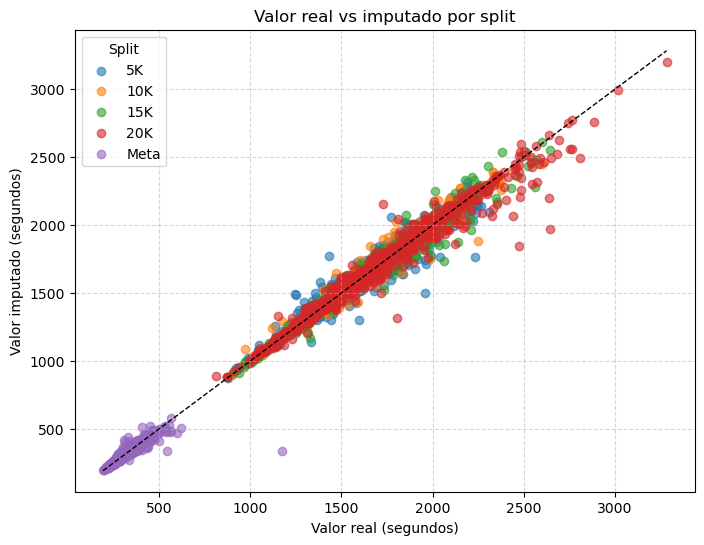

In [75]:
df_wide = preparar_datos_maraton(athletes_events_df, athletes_time_df, athletes_df,
                                                             race_id_filter='b228b93e-2a15-4123-baf9-ca0915165c6a',
                                                             event_std_filter='media', split_cols=split_cols)

df_imputed_sec, comparison, mae_per_split, mae_overall, df_wide = imputacion_knn(df_wide, split_cols,
                                                                                             nan_fraction=0.2)

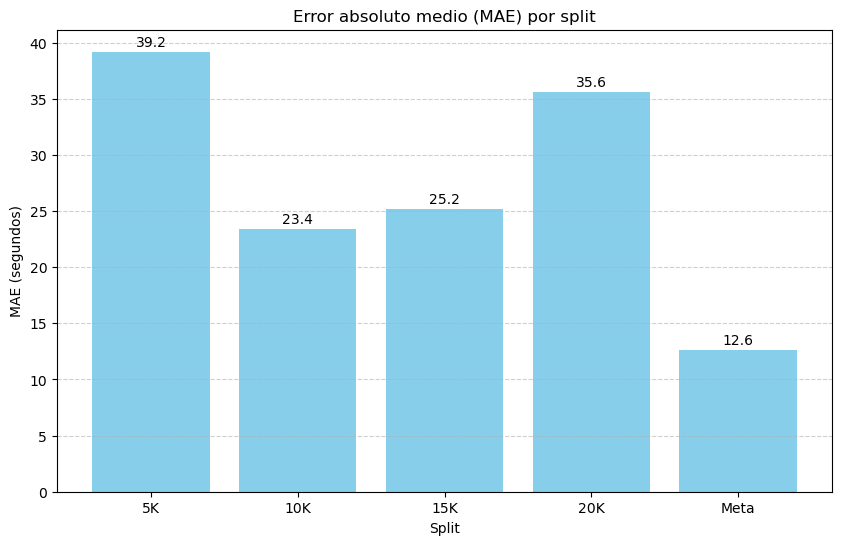

In [76]:
splits_ordered = [s for s in split_cols if s in mae_per_split]
mae_values_ordered = [mae_per_split[s] for s in splits_ordered]

plt.figure(figsize=(10,6))
plt.bar(splits_ordered, mae_values_ordered, color='skyblue')
plt.xlabel('Split')
plt.ylabel('MAE (segundos)')
plt.title('Error absoluto medio (MAE) por split')
plt.grid(axis='y', linestyle='--', alpha=0.6)

for i, v in enumerate(mae_values_ordered):
    plt.text(i, v + 0.2, f"{v:.1f}", ha='center', va='bottom')

plt.show()

In [77]:
df_mal, df_bien, df_comparacion, df_splits, df_features = analisis_mal_imputado(df_wide, comparison)

C:\Users\mario\AppData\Local\Temp\ipykernel_12360\2629461495.py:18: FutureWarning:

The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior



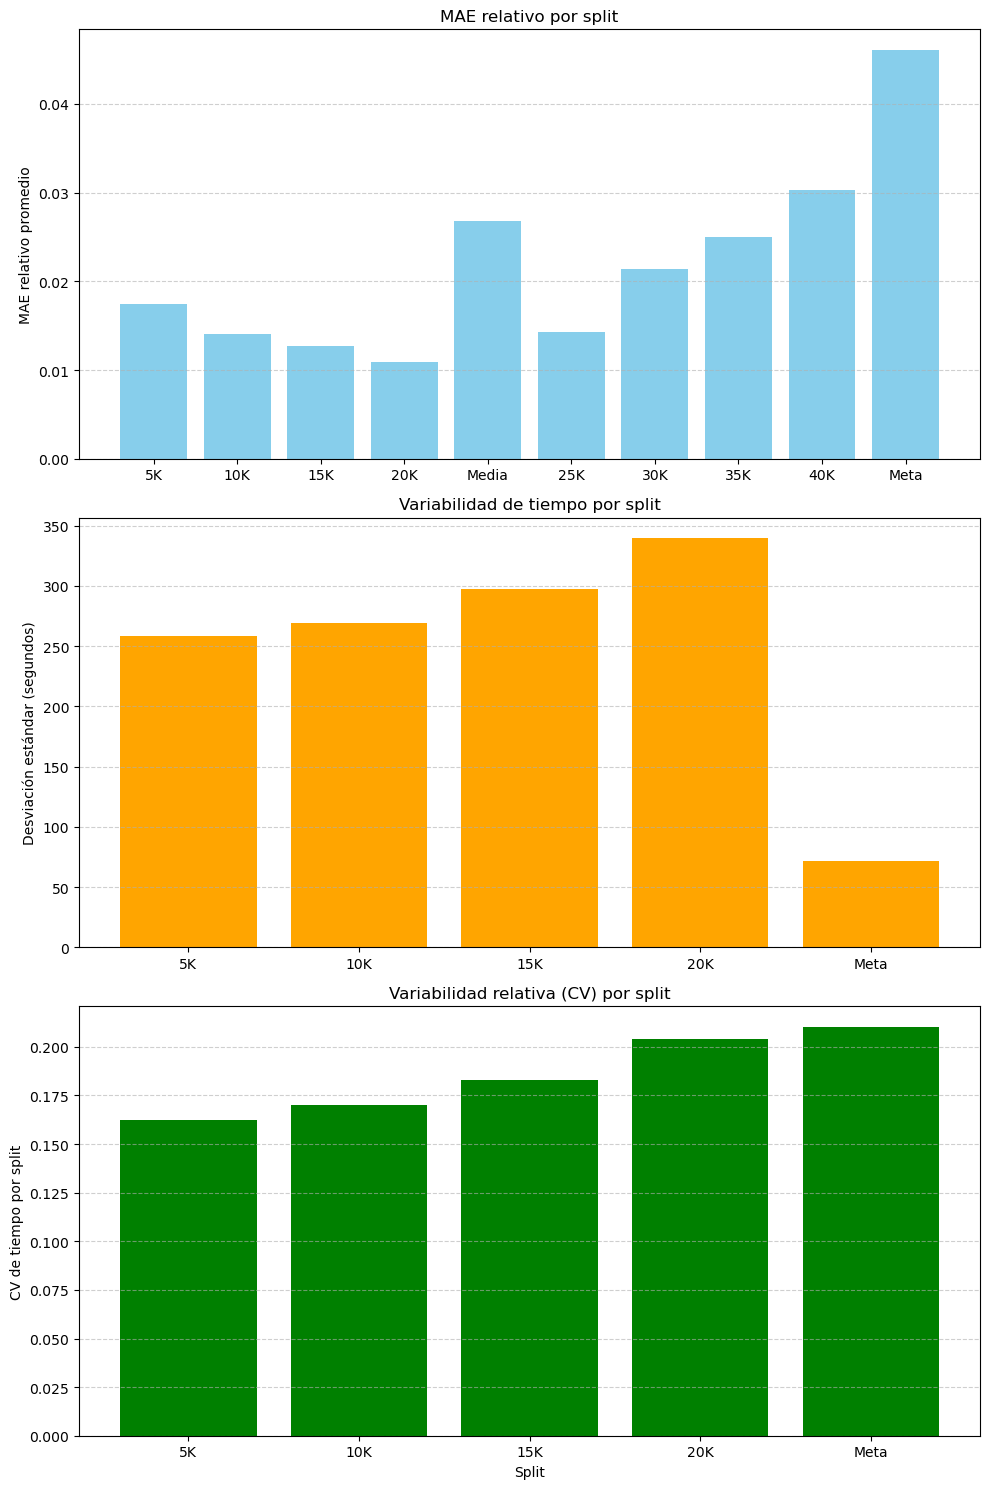

In [78]:
graficos_variabilidad_split(mae_por_split, df_wide, split_cols)

In [79]:
resumen_grupos_error(df_mal)

Grupo ≥10%: 104 atletas
Grupo ≥25%: 9 atletas
Grupo ≥50%: 1 atletas
Grupo ≥100%: 0 atletas


In [80]:
comparison['fue_imputado'] = comparison['abs_error'] > 0

atletas_bien_imputados = comparison[(comparison['fue_imputado']) & 
                                    (comparison['abs_error'] <= 0.1 * comparison['valor_real'])]['athlete_id'].unique()

print("Número de atletas imputados con error ≤10%:", len(atletas_bien_imputados))

Número de atletas imputados con error ≤10%: 5138


In [81]:
todos_atletas = df_wide['athlete_id'].unique()
atletas_imputados = np.union1d(atletas_bien_imputados, df_mal['athlete_id'].unique())
atletas_no_imputados = np.setdiff1d(todos_atletas, atletas_imputados)

print("Número de atletas no imputados:", len(atletas_no_imputados))

Número de atletas no imputados: 20994


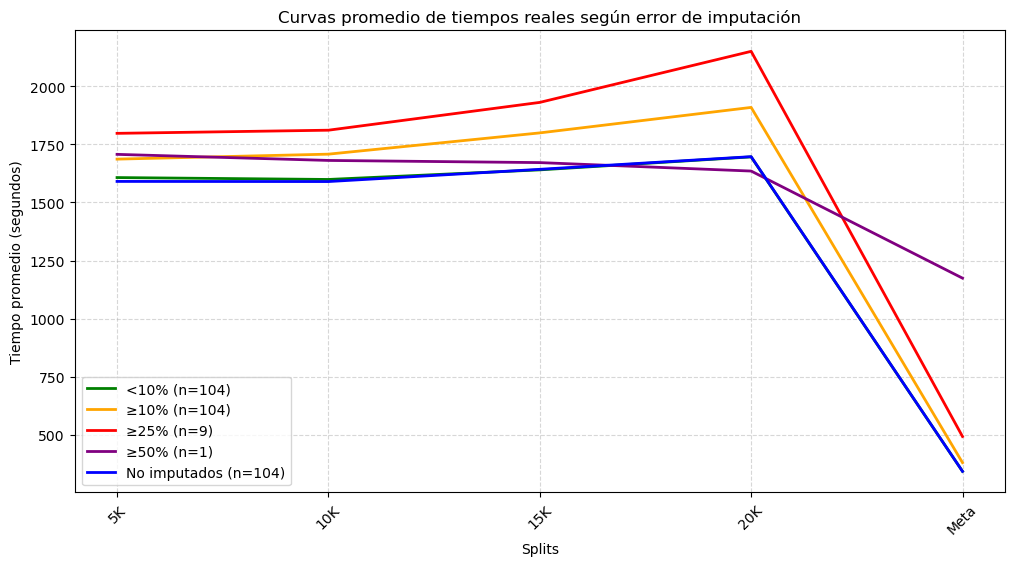

In [82]:
graficar_curvas_error_imputacion(df_wide, df_mal, atletas_bien_imputados, atletas_no_imputados)

In [83]:
conteo, atleta_id, tiempo, errores = analizar_mejores_atletas(df_wide, df_mal, atletas_bien_imputados)

Atleta más rápido imputado: 2YZC1CB7
Tiempo total real: 4622.75 segundos
Errores de imputación por split:
     split  valor_real  valor_imputado   abs_error
1142   10K     970.995     1084.921303  113.926303


### otra media maraton

In [86]:
split_cols = ['5K', '10K', '15K', '19K', 'Meta']

INFO: Filtrando eventos completos y tipo de evento
INFO: Merge de tiempos y eventos
INFO: Filtrado por race_id=01675eec-4b8b-4b92-80b7-5e22a1878f38, filas restantes: 103691
INFO: n_neighbors=5: MAE=30.98 seg
INFO: n_neighbors=10: MAE=29.30 seg
INFO: n_neighbors=15: MAE=28.92 seg
INFO: n_neighbors=20: MAE=28.80 seg
INFO: n_neighbors=25: MAE=28.81 seg
INFO: n_neighbors=30: MAE=28.85 seg
INFO: n_neighbors=50: MAE=28.94 seg
INFO: n_neighbors=100: MAE=29.37 seg
INFO: n_neighbors=200: MAE=30.23 seg
INFO: Mejor n_neighbors=20 con MAE=28.80 seg
C:\Users\mario\AppData\Local\Temp\ipykernel_12360\2497849520.py:124: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



<Figure size 800x500 with 0 Axes>

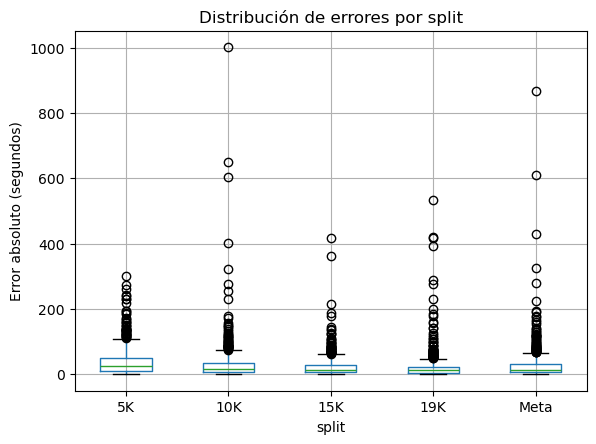

<Figure size 600x500 with 0 Axes>

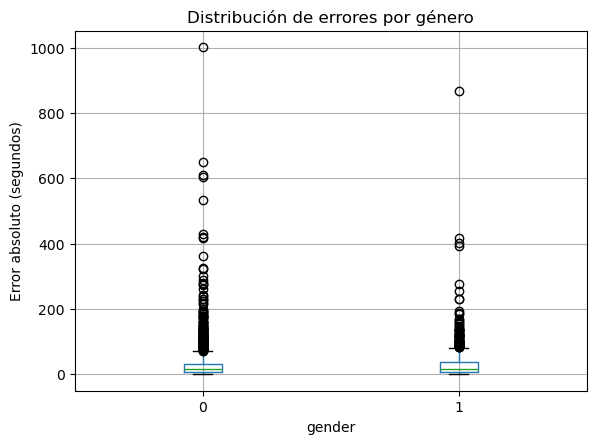

<Figure size 800x500 with 0 Axes>

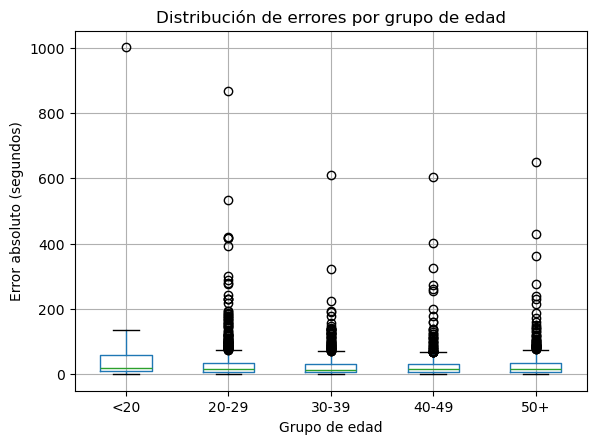

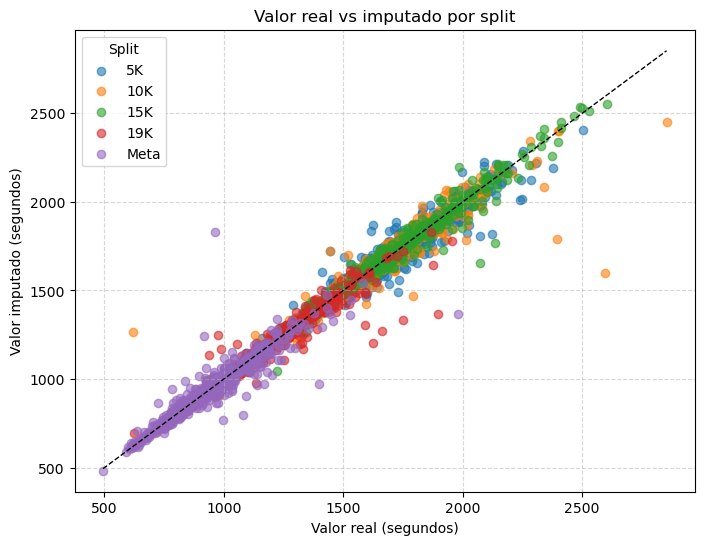

In [88]:
df_wide = preparar_datos_maraton(athletes_events_df, athletes_time_df, athletes_df,
                                                             race_id_filter='01675eec-4b8b-4b92-80b7-5e22a1878f38',
                                                             event_std_filter='media', split_cols=split_cols)

df_imputed_sec, comparison, mae_per_split, mae_overall, df_wide = imputacion_knn(df_wide, split_cols,
                                                                                             nan_fraction=0.2)

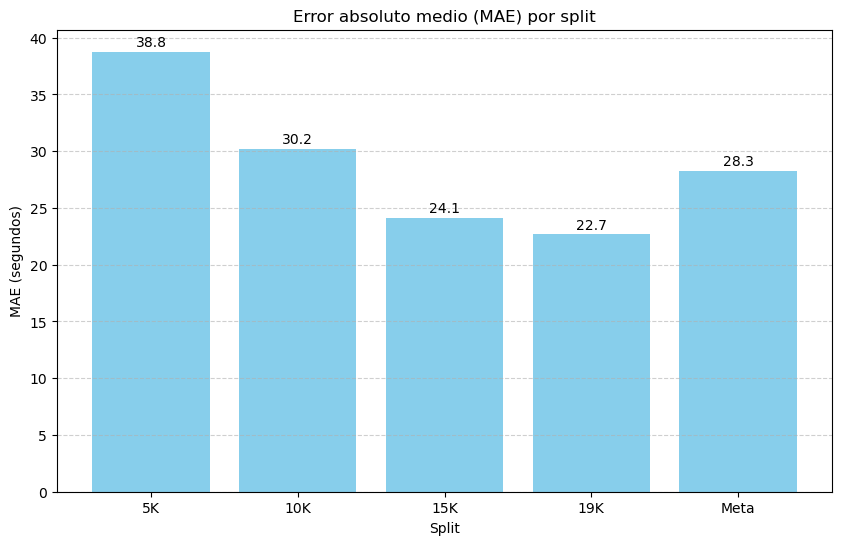

In [89]:
splits_ordered = [s for s in split_cols if s in mae_per_split]
mae_values_ordered = [mae_per_split[s] for s in splits_ordered]

plt.figure(figsize=(10,6))
plt.bar(splits_ordered, mae_values_ordered, color='skyblue')
plt.xlabel('Split')
plt.ylabel('MAE (segundos)')
plt.title('Error absoluto medio (MAE) por split')
plt.grid(axis='y', linestyle='--', alpha=0.6)

for i, v in enumerate(mae_values_ordered):
    plt.text(i, v + 0.2, f"{v:.1f}", ha='center', va='bottom')

plt.show()

In [90]:
df_mal, df_bien, df_comparacion, df_splits, df_features = analisis_mal_imputado(df_wide, comparison)

C:\Users\mario\AppData\Local\Temp\ipykernel_12360\2629461495.py:18: FutureWarning:

The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior



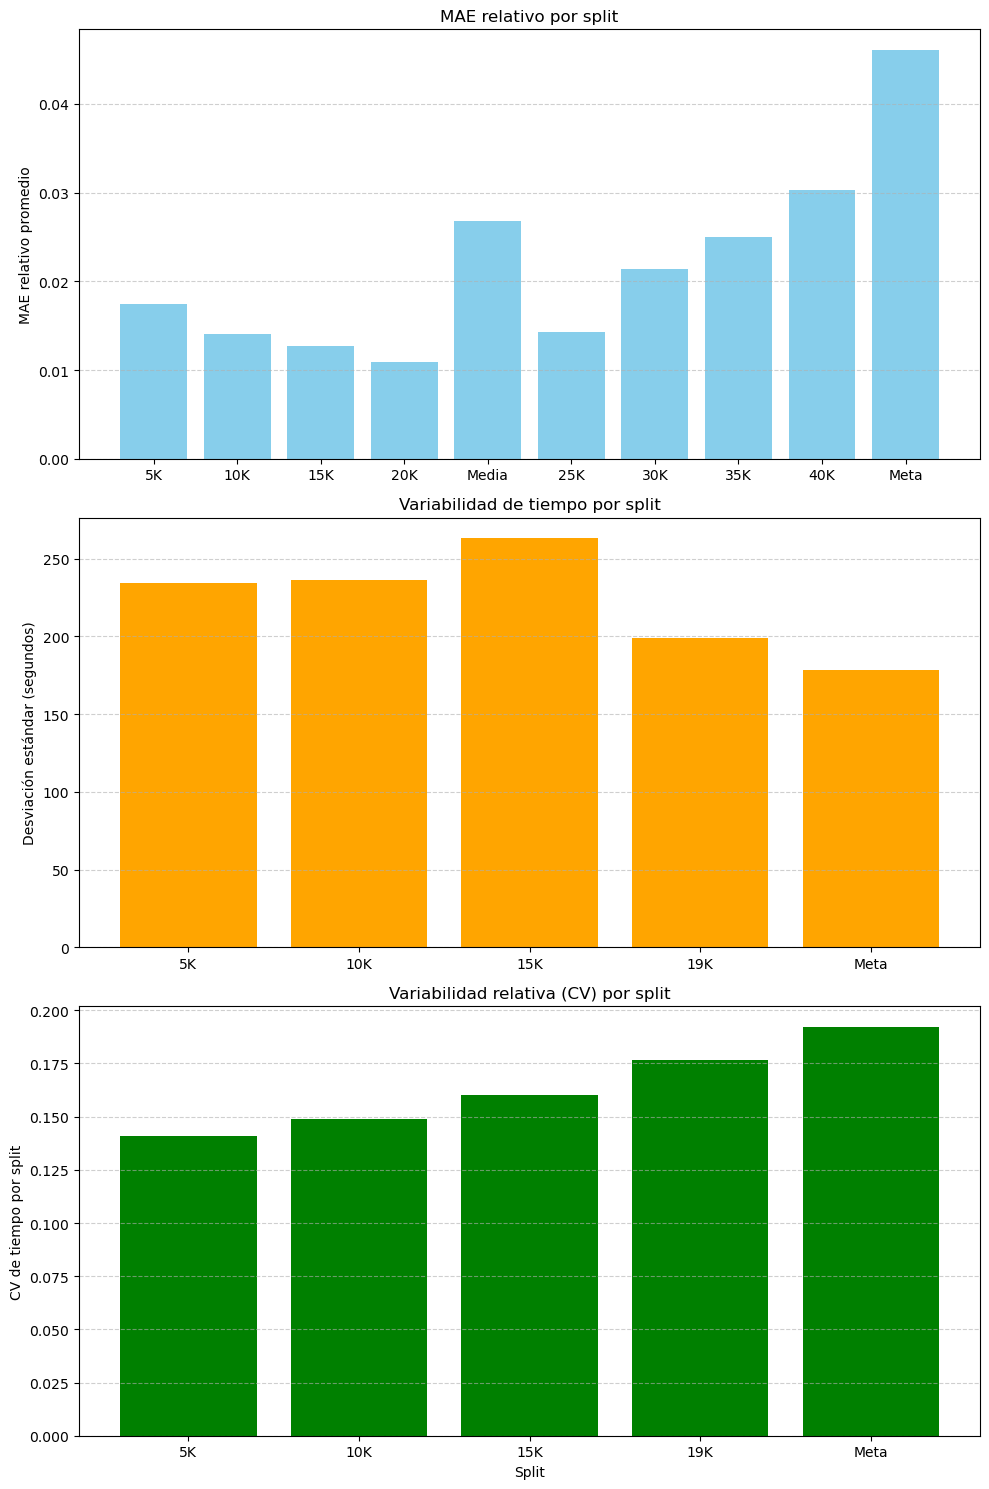

In [91]:
graficos_variabilidad_split(mae_por_split, df_wide, split_cols)

In [92]:
resumen_grupos_error(df_mal)

Grupo ≥10%: 66 atletas
Grupo ≥25%: 11 atletas
Grupo ≥50%: 2 atletas
Grupo ≥100%: 1 atletas


In [93]:
comparison['fue_imputado'] = comparison['abs_error'] > 0

atletas_bien_imputados = comparison[(comparison['fue_imputado']) & 
                                    (comparison['abs_error'] <= 0.1 * comparison['valor_real'])]['athlete_id'].unique()

print("Número de atletas imputados con error ≤10%:", len(atletas_bien_imputados))

Número de atletas imputados con error ≤10%: 3357


In [94]:
todos_atletas = df_wide['athlete_id'].unique()
atletas_imputados = np.union1d(atletas_bien_imputados, df_mal['athlete_id'].unique())
atletas_no_imputados = np.setdiff1d(todos_atletas, atletas_imputados)

print("Número de atletas no imputados:", len(atletas_no_imputados))

Número de atletas no imputados: 13696


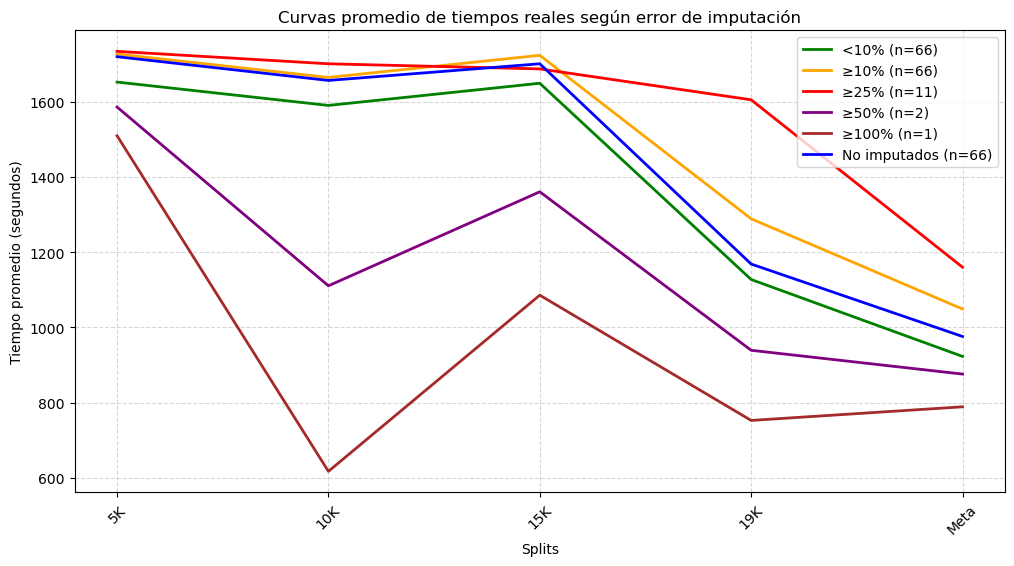

In [95]:
graficar_curvas_error_imputacion(df_wide, df_mal, atletas_bien_imputados, atletas_no_imputados)

In [96]:
conteo, atleta_id, tiempo, errores = analizar_mejores_atletas(df_wide, df_mal, atletas_bien_imputados)

Atleta más rápido imputado: 45
Tiempo total real: 4222.30 segundos
Errores de imputación por split:
     split  valor_real  valor_imputado  abs_error
2552   19K     621.898      692.723244  70.825244


## Ajuste temporal

### 1. Filtrado de eventos completos

Se seleccionan únicamente los eventos que tienen todos los splits completos (`splitsMissing == 0`) y sin splits consecutivos faltantes (`maxConsecutiveSplitsMissing == 0`), filtrando además por el tipo de evento (`event_std`). Esto asegura que el análisis se realice sobre datos consistentes y comparables.

### 2. Combinación de datos de splits y atletas

Se realiza un merge entre los datos de splits (`athletes_time_df`) y los eventos filtrados para obtener únicamente los splits completos.  
Posteriormente, se integran datos biográficos de los atletas (`athletes_df`), como fecha de nacimiento, género y club.

### 3. Filtrado opcional por carrera

Si se proporciona un `race_id_filter`, se seleccionan únicamente los splits correspondientes a esa carrera específica. Esto permite realizar análisis enfocados en un evento particular, descartando datos de otras carreras.

### 4. Selección de columnas relevantes

Se conservan únicamente las columnas necesarias para el análisis (`athlete_id`, `event_id`, `race_id`, `split`, `time_split_sec`, `gender`, `birthdate`, `club`).

### 5. Eliminación de splits de salida y valores faltantes

Se excluyen los splits denominados `Salida` y cualquier registro con valores nulos en columnas críticas (`time_split_sec`, `birthdate`). Esto garantiza que el dataset esté limpio y preparado para análisis posteriores.

### 6. Pivot de splits

Se transforma el dataset a formato “wide”, donde cada split se convierte en una columna y cada fila corresponde a un atleta y un evento. Esto facilita cálculos por split y la aplicación de técnicas de clustering o imputación.

### 7. Cálculo de edad y codificación de género

Se calcula la edad de cada atleta al momento de la carrera restando la fecha de nacimiento de la fecha de la carrera (`race_date`).  
El género se codifica numéricamente (`male=0`, `female=1`) para permitir el uso de esta variable en análisis estadísticos y algoritmos de aprendizaje automático.

### 8. Integración final y limpieza

Se combinan los datos de splits con la información de edad, género y club. Finalmente, se eliminan filas con valores faltantes (`dropna`) para asegurar consistencia en el análisis de clustering.

### 9. Resultado

El dataset resultante (`df_wide_clean`) contiene splits completos por atleta y evento, junto con información biográfica relevante, listo para análisis exploratorio, visualización y clustering.


In [71]:

import logging
import pandas as pd

logging.basicConfig(level=logging.INFO, format='%(levelname)s: %(message)s')

def extraer_datos_splits_completos(
    athletes_events_df, athletes_time_df, athletes_df,
    race_id_filter=None, event_std_filter='media'
):
    """
    Extrae splits completos, pivota los datos y añade información de edad y género.
    Muestra logs y head(5) de los DataFrames creados en cada paso.
    """
    logging.info("=== athletes_events_df columnas ===")
    print(athletes_events_df.columns.tolist())
    logging.info("Primeros 5 registros de athletes_events_df")
    print(athletes_events_df.head(5))

    logging.info("Filtrando eventos por splits completos y tipo de evento")
    filtered_events = athletes_events_df[
        (athletes_events_df['splitsMissing'] == 0) &
        (athletes_events_df['maxConsecutiveSplitsMissing'] == 0) &
        (athletes_events_df['event_std'] == event_std_filter)
    ][['athlete_id', 'event_id', 'event_std', 'race_id']]
    logging.info("=== filtered_events columnas ===")
    print(filtered_events.columns.tolist())
    logging.info("Primeros 5 registros de filtered_events")
    print(filtered_events.head(5))

    logging.info("Merge inicial para obtener tiempos y splits")
    df_merged = athletes_time_df.merge(
        filtered_events, on=['athlete_id', 'event_id', 'race_id', 'event_std'], how='inner'
    )
    logging.info("=== df_merged columnas después del merge con filtered_events ===")
    print(df_merged.columns.tolist())
    logging.info("Primeros 5 registros de df_merged")
    print(df_merged.head(5))

    df_merged = df_merged.merge(
        athletes_df[['athlete_id', 'birthdate', 'gender', 'club']], on='athlete_id', how='left'
    )
    logging.info("=== df_merged columnas después del merge con athletes_df ===")
    print(df_merged.columns.tolist())
    logging.info("Primeros 5 registros de df_merged tras merge con athletes_df")
    print(df_merged.head(5))

    if race_id_filter is not None:
        if 'race_id' in df_merged.columns:
            df_merged = df_merged[df_merged['race_id'] == race_id_filter].copy()
            logging.info(f"Filtrado por race_id={race_id_filter}, filas restantes: {len(df_merged)}")
        else:
            logging.warning("'race_id' no encontrado en df_merged, se omite filtrado")

    cols_to_keep = ['athlete_id', 'event_id', 'race_id', 'split', 'time_split_sec', 'gender', 'birthdate', 'club']
    df_subset = df_merged[[c for c in cols_to_keep if c in df_merged.columns]].copy()
    logging.info("=== df_subset columnas ===")
    print(df_subset.columns.tolist())
    logging.info("Primeros 5 registros de df_subset")
    print(df_subset.head(5))

    df_subset = df_subset[df_subset['split'] != 'Salida'].dropna(subset=['time_split_sec', 'birthdate'])
    logging.info("=== df_subset columnas después de filtrar 'Salida' y NA ===")
    print(df_subset.columns.tolist())
    logging.info("Primeros 5 registros de df_subset filtrado")
    print(df_subset.head(5))

    index_cols = ['athlete_id', 'event_id']
    if 'race_id' in df_subset.columns:
        index_cols.insert(1, 'race_id')
    df_wide = df_subset.pivot_table(
        index=index_cols,
        columns='split',
        values='time_split_sec'
    ).reset_index()
    logging.info("=== df_wide columnas después del pivot ===")
    print(df_wide.columns.tolist())
    logging.info("Primeros 5 registros de df_wide")
    print(df_wide.head(5))

    df_subset['birthdate'] = pd.to_datetime(df_subset['birthdate'])
    df_subset['race_date'] = pd.to_datetime(df_subset.get('race_date', pd.Timestamp.today()))
    athletes_info = df_subset.groupby('athlete_id').first()[['gender', 'birthdate', 'race_date', 'club']].reset_index()
    athletes_info['age'] = (athletes_info['race_date'] - athletes_info['birthdate']).dt.days / 365.25
    athletes_info['gender'] = athletes_info['gender'].map({'male': 0, 'female': 1})
    logging.info("Primeros 5 registros de athletes_info (edad y género calculados)")
    print(athletes_info.head(5))

    df_wide = df_wide.merge(
        athletes_info[['athlete_id', 'gender', 'age', 'club']], on='athlete_id', how='left'
    )
    logging.info("=== df_wide columnas después de merge con edad y gender ===")
    print(df_wide.columns.tolist())
    logging.info("Primeros 5 registros de df_wide final")
    print(df_wide.head(5))

    df_wide_clean = df_wide.dropna()
    logging.info("Datos listos para clustering")
    
    return df_wide_clean

In [72]:
df_subset = athletes_events_df[
    (athletes_events_df['race_id'] == 'b228b93e-2a15-4123-baf9-ca0915165c6a') &
    (athletes_events_df['event_id'] == 'Mitja')
]

max_splits = df_subset['splitsSeen'].max()

df_filtered = df_subset[
    (df_subset['splitsMissing'] == 0) &
    (df_subset['maxConsecutiveSplitsMissing'] == 0) &
    (df_subset['splitsSeen'] < max_splits)
]

df_filtered[['athlete_id', 'event_id', 'race_id', 'splitsMissing', 'maxConsecutiveSplitsMissing', 'splitsSeen', 'last_split_seen']].head(5)

athlete_id event_id                               race_id  splitsMissing  \
0          31    Mitja  b228b93e-2a15-4123-baf9-ca0915165c6a              0   
5         193    Mitja  b228b93e-2a15-4123-baf9-ca0915165c6a              0   
6         194    Mitja  b228b93e-2a15-4123-baf9-ca0915165c6a              0   
16   C29C3BY4    Mitja  b228b93e-2a15-4123-baf9-ca0915165c6a              0   
26   75YYC4C5    Mitja  b228b93e-2a15-4123-baf9-ca0915165c6a              0   

    maxConsecutiveSplitsMissing  splitsSeen last_split_seen  
0                             0           2              5K  
5                             0           0      notstarted  
6                             0           0      notstarted  
16                            0           0      notstarted  
26                            0           0      notstarted

In [73]:
df_wide = extraer_datos_splits_completos(athletes_events_df, athletes_time_df, athletes_df,
    race_id_filter='b228b93e-2a15-4123-baf9-ca0915165c6a', event_std_filter='media')

INFO: === athletes_events_df columnas ===
INFO: Primeros 5 registros de athletes_events_df
INFO: Filtrando eventos por splits completos y tipo de evento
INFO: === filtered_events columnas ===
INFO: Primeros 5 registros de filtered_events
INFO: Merge inicial para obtener tiempos y splits


['athlete_id', 'auto_category', 'auto_chip', 'category', 'distance', 'dorsal', 'event_id', 'gunTime', 'gunTimeMode', 'gunTimeModeConfig_wave', 'last_split_seen', 'maxConsecutiveSplitsMissing', 'race_id', 'realStatus', 'splitsMissing', 'splitsSeen', 'startNetTime', 'startRawTime', 'startTime', 'status', 'team', 'event_std', 'startNetTime_td', 'startTime_td']
  athlete_id  auto_category  auto_chip  category  distance dorsal event_id  \
0         31           True       True  Senior M      5000     31    Mitja   
1        159           True       True  Senior F     21097    159    Mitja   
2        160           True       True  Senior F     21097    160    Mitja   
3        191           True       True  Senior M     21097    191    Mitja   
4        192           True       True  Senior M     21097    192    Mitja   

                    gunTime gunTimeMode gunTimeModeConfig_wave  \
0 2025-02-16 07:31:06+00:00        wave                   8:30   
1 2025-02-16 07:31:06+00:00        wave

INFO: === df_merged columnas después del merge con filtered_events ===
INFO: Primeros 5 registros de df_merged
INFO: === df_merged columnas después del merge con athletes_df ===


['athlete_id', 'average', 'distance', 'event_id', 'incidence', 'isBackup', 'netTime', 'offset', 'order', 'race_id', 'rawTime', 'split', 'time', 'event_std', 'netTime_td', 'time_td', 'time_split_sec', 'prev_split', 'split_order']
  athlete_id  average  distance event_id incidence isBackup    netTime  \
0         31  0.00000         0    Mitja       NaN      NaN        0.0   
1         31  0.17876      5000    Mitja       NaN      NaN   891230.0   
2        159  0.00000         0    Mitja       NaN      NaN        0.0   
3        159  0.21763      5000    Mitja       NaN      NaN  1081165.0   
4        159  0.21633     10000    Mitja       NaN      NaN  2156349.0   

   offset  order                               race_id  \
0     NaN      1  b228b93e-2a15-4123-baf9-ca0915165c6a   
1     NaN      2  b228b93e-2a15-4123-baf9-ca0915165c6a   
2     NaN      1  b228b93e-2a15-4123-baf9-ca0915165c6a   
3     NaN      2  b228b93e-2a15-4123-baf9-ca0915165c6a   
4     NaN      3  b228b93e-2a15-4123

INFO: Primeros 5 registros de df_merged tras merge con athletes_df
INFO: Filtrado por race_id=b228b93e-2a15-4123-baf9-ca0915165c6a, filas restantes: 158557
INFO: === df_subset columnas ===
INFO: Primeros 5 registros de df_subset
INFO: === df_subset columnas después de filtrar 'Salida' y NA ===


['athlete_id', 'average', 'distance', 'event_id', 'incidence', 'isBackup', 'netTime', 'offset', 'order', 'race_id', 'rawTime', 'split', 'time', 'event_std', 'netTime_td', 'time_td', 'time_split_sec', 'prev_split', 'split_order', 'birthdate', 'gender', 'club']
  athlete_id  average  distance event_id incidence isBackup   netTime  offset  \
0         31  0.00000         0    Mitja       NaN      NaN       0.0     NaN   
1         31  0.00000         0    Mitja       NaN      NaN       0.0     NaN   
2         31  0.17876      5000    Mitja       NaN      NaN  891230.0     NaN   
3         31  0.17876      5000    Mitja       NaN      NaN  891230.0     NaN   
4        159  0.00000         0    Mitja       NaN      NaN       0.0     NaN   

   order                               race_id                 rawTime  \
0      1  b228b93e-2a15-4123-baf9-ca0915165c6a 2025-02-16 07:31:08.560   
1      1  b228b93e-2a15-4123-baf9-ca0915165c6a 2025-02-16 07:31:08.560   
2      2  b228b93e-2a15-4123-ba

INFO: Primeros 5 registros de df_subset filtrado
INFO: === df_wide columnas después del pivot ===


['athlete_id', 'event_id', 'race_id', 'split', 'time_split_sec', 'gender', 'birthdate', 'club']
  athlete_id event_id                               race_id split  \
2         31    Mitja  b228b93e-2a15-4123-baf9-ca0915165c6a    5K   
3         31    Mitja  b228b93e-2a15-4123-baf9-ca0915165c6a    5K   
5        159    Mitja  b228b93e-2a15-4123-baf9-ca0915165c6a    5K   
6        159    Mitja  b228b93e-2a15-4123-baf9-ca0915165c6a   10K   
7        159    Mitja  b228b93e-2a15-4123-baf9-ca0915165c6a   15K   

   time_split_sec  gender  birthdate club  
2         891.230    male 1991-08-30       
3         891.230    male 1986-05-24       
5        1081.165  female 1991-04-27       
6        1075.184  female 1991-04-27       
7        1075.456  female 1991-04-27       


INFO: Primeros 5 registros de df_wide
INFO: Primeros 5 registros de athletes_info (edad y género calculados)
INFO: === df_wide columnas después de merge con edad y gender ===


['athlete_id', 'race_id', 'event_id', '10K', '15K', '20K', '5K', 'Meta']
split athlete_id                               race_id event_id       10K  \
0       1111B6ZY  b228b93e-2a15-4123-baf9-ca0915165c6a    Mitja  1633.132   
1       1118BZ53  b228b93e-2a15-4123-baf9-ca0915165c6a    Mitja  1395.566   
2       111CC3F8  b228b93e-2a15-4123-baf9-ca0915165c6a    Mitja  1863.922   
3       111CZ127  b228b93e-2a15-4123-baf9-ca0915165c6a    Mitja  1112.130   
4       112BYA92  b228b93e-2a15-4123-baf9-ca0915165c6a    Mitja  1472.889   

split       15K       20K        5K     Meta  
0      1625.279  1625.978  1594.475  325.888  
1      1382.856  1401.240  1393.216  287.454  
2      1862.845  1855.556  1904.496  381.822  
3      1134.049  1177.837  1118.088  258.167  
4      1470.094  1463.164  1521.806  299.681  
  athlete_id  gender  birthdate                  race_date              club  \
0   1111B6ZY     0.0 1991-11-11 2025-12-04 09:52:35.992125     Independiente   
1   1118BZ53     0.0 1

INFO: Primeros 5 registros de df_wide final
INFO: Datos listos para clustering


['athlete_id', 'race_id', 'event_id', '10K', '15K', '20K', '5K', 'Meta', 'gender', 'age', 'club']
  athlete_id                               race_id event_id       10K  \
0   1111B6ZY  b228b93e-2a15-4123-baf9-ca0915165c6a    Mitja  1633.132   
1   1118BZ53  b228b93e-2a15-4123-baf9-ca0915165c6a    Mitja  1395.566   
2   111CC3F8  b228b93e-2a15-4123-baf9-ca0915165c6a    Mitja  1863.922   
3   111CZ127  b228b93e-2a15-4123-baf9-ca0915165c6a    Mitja  1112.130   
4   112BYA92  b228b93e-2a15-4123-baf9-ca0915165c6a    Mitja  1472.889   

        15K       20K        5K     Meta  gender        age              club  
0  1625.279  1625.978  1594.475  325.888     0.0  34.064339     Independiente  
1  1382.856  1401.240  1393.216  287.454     0.0  36.703628     Independiente  
2  1862.845  1855.556  1904.496  381.822     1.0  38.299795     Independiente  
3  1134.049  1177.837  1118.088  258.167     0.0  29.336071  CE ILLES BALEARS  
4  1470.094  1463.164  1521.806  299.681     0.0  48.350445    

In [74]:
df_wide_with_nan = df_wide[df_wide.isna().any(axis=1)]
print(df_wide_with_nan)

Empty DataFrame
Columns: [athlete_id, race_id, event_id, 10K, 15K, 20K, 5K, Meta, gender, age, club]
Index: []


In [75]:
df_wide.head(5)

athlete_id                               race_id event_id       10K  \
0   1111B6ZY  b228b93e-2a15-4123-baf9-ca0915165c6a    Mitja  1633.132   
1   1118BZ53  b228b93e-2a15-4123-baf9-ca0915165c6a    Mitja  1395.566   
2   111CC3F8  b228b93e-2a15-4123-baf9-ca0915165c6a    Mitja  1863.922   
3   111CZ127  b228b93e-2a15-4123-baf9-ca0915165c6a    Mitja  1112.130   
4   112BYA92  b228b93e-2a15-4123-baf9-ca0915165c6a    Mitja  1472.889   

        15K       20K        5K     Meta  gender        age              club  
0  1625.279  1625.978  1594.475  325.888     0.0  34.064339     Independiente  
1  1382.856  1401.240  1393.216  287.454     0.0  36.703628     Independiente  
2  1862.845  1855.556  1904.496  381.822     1.0  38.299795     Independiente  
3  1134.049  1177.837  1118.088  258.167     0.0  29.336071  CE ILLES BALEARS  
4  1470.094  1463.164  1521.806  299.681     0.0  48.350445     Independiente

In [76]:
df_wide['gender_label'] = df_wide['gender'].map({0: 'Hombre', 1: 'Mujer'})

In [77]:
df_wide.head(5)

athlete_id                               race_id event_id       10K  \
0   1111B6ZY  b228b93e-2a15-4123-baf9-ca0915165c6a    Mitja  1633.132   
1   1118BZ53  b228b93e-2a15-4123-baf9-ca0915165c6a    Mitja  1395.566   
2   111CC3F8  b228b93e-2a15-4123-baf9-ca0915165c6a    Mitja  1863.922   
3   111CZ127  b228b93e-2a15-4123-baf9-ca0915165c6a    Mitja  1112.130   
4   112BYA92  b228b93e-2a15-4123-baf9-ca0915165c6a    Mitja  1472.889   

        15K       20K        5K     Meta  gender        age              club  \
0  1625.279  1625.978  1594.475  325.888     0.0  34.064339     Independiente   
1  1382.856  1401.240  1393.216  287.454     0.0  36.703628     Independiente   
2  1862.845  1855.556  1904.496  381.822     1.0  38.299795     Independiente   
3  1134.049  1177.837  1118.088  258.167     0.0  29.336071  CE ILLES BALEARS   
4  1470.094  1463.164  1521.806  299.681     0.0  48.350445     Independiente   

  gender_label  
0       Hombre  
1       Hombre  
2        Mujer  
3       Hombre  
4       Hombre

### KMeans

Se seleccionan las columnas de splits que se usarán para el clustering:

$$

X = 
\begin{bmatrix}
x_{1, \text{5K}} & x_{1, \text{10K}} & x_{1, \text{15K}} & x_{1, \text{20K}} & x_{1, \text{Meta}} \\
x_{2, \text{5K}} & x_{2, \text{10K}} & x_{2, \text{15K}} & x_{2, \text{20K}} & x_{2, \text{Meta}} \\
\vdots & \vdots & \vdots & \vdots & \vdots \\
x_{n, \text{5K}} & x_{n, \text{10K}} & x_{n, \text{15K}} & x_{n, \text{20K}} & x_{n, \text{Meta}}
\end{bmatrix}

$$ 

Cada fila representa un atleta, cada columna un split. Se mantiene el orden temporal.

Se normalizan los datos para que cada columna tenga media 0 y desviación estándar 1:

$$
X_{\text{scaled}}[:, j] = \frac{X[:, j] - \mu_j}{\sigma_j}
$$

donde:
$$
\mu_j = \frac{1}{n} \sum_{i=1}^{n} X_{ij}, \quad
\sigma_j = \sqrt{\frac{1}{n} \sum_{i=1}^{n} (X_{ij} - \mu_j)^2}
$$

Se evalúan diferentes valores de \(k\) para encontrar el número óptimo de clusters utilizando el método del codo (Elbow Method).

Para cada valor de \(k\):

$$
\{C_1, C_2, \dots, C_k\} = \text{KMeans}(X_{\text{scaled}})
$$

- Cada \(C_m\) es el centroide de un cluster.  
- Se minimiza la \textbf{inercia}:

$$
\text{Inercia} = \sum_{i=1}^{n} \min_{1 \le m \le k} \| x_i - C_m \|^2
$$

- Esto representa la suma de errores cuadráticos de cada punto respecto a su centroide asignado.

- Se grafica la inercia en función de \(k\) para identificar el codo, punto donde agregar más clusters aporta poco beneficio.  
- Cada cluster representa un grupo de atletas con comportamiento de splits similar.  
- El escalado asegura que todos los splits contribuyan de forma equilibrada al cálculo de distancias.

#### Copia y eliminación de outliers
- Se realiza una copia del DataFrame df_wide para preservar el original.
- Para cada split, se calcula el rango intercuartílico (IQR) y se eliminan los valores mayores a Q3 + 3*IQR, que se consideran outliers.
$$
x_i \text{ se elimina si } x_i > Q3 + 1.5 \cdot (Q3 - Q1)
$$

#### Transformación logarítmica
- Se aplica la transformación log(1 + x) a los tiempos de splits.
- Esta transformación reduce la influencia de valores extremos y mejora la normalidad de la distribución.
$$
x' = \log(1 + x)
$$

#### Escalado de datos
- Se extraen los valores de splits a un array X y se aplica StandardScaler para que cada split tenga media 0 y desviación estándar 1:
- Esto asegura que todos los splits contribuyan de manera equitativa al cálculo de distancias en KMeans.

#### Búsqueda del número óptimo de clusters
- Se definen varios valores de k (número de clusters) y se aplica MiniBatchKMeans para cada uno.
- Para cada clustering, se calcula el Silhouette Score:
$$
s(i) = \frac{b(i) - a(i)}{\max(a(i), b(i))}
$$
donde \(a(i)\) es la distancia media del punto i a su cluster y \(b(i)\) es la distancia media mínima a otros clusters.
- Se selecciona el k que maximiza el Silhouette Score, es decir, que genera clusters más compactos y separados.

#### Asignación de clusters y centroides
- Se asigna a cada fila su cluster correspondiente.
- Los centroides se encuentran en escala estandarizada y luego se transforman a los valores originales en segundos:
$$
\text{centroides\_reales} = \exp(\text{scaler.inverse\_transform(centroides\_escalados)}) - 1
$$

#### Visualización
- Se grafican los centroides de cada cluster a lo largo de los splits para identificar patrones de ritmo.
- Se utiliza el Elbow Method para visualizar la inercia (suma de errores cuadráticos) y apoyar la elección de k óptimo:
donde \(x_i\) es un punto de datos y \(\mu_{c(i)}\) es el centroide de su cluster.

#### Salida
- df_wide_clean con asignación de cluster.
- centroid_df con los centroides en segundos de cada cluster.
- Gráficos de centroides y curva de inercia para análisis visual del clustering.


In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

def cluster_splits_KNN(df_wide, ordered_splits, k_values=[2,3,4,5,6,7,8,9,10,12,15], iqr_multiplier=3, random_state=42):
    """
    Limpia outliers, transforma datos, aplica MiniBatchKMeans para varios k y devuelve resultados y gráficos.
    
    Parámetros:
    - df_wide: DataFrame con los splits como columnas.
    - ordered_splits: lista de nombres de columnas de splits.
    - k_values: lista de valores de k a evaluar.
    - iqr_multiplier: multiplicador para definir outliers (default=3).
    - random_state: semilla para reproducibilidad.
    
    Retorna:
    - df_wide_clean: DataFrame con la columna 'cluster' asignada.
    - centroid_df: DataFrame con centroides de cada cluster en segundos.
    - best_k: valor óptimo de k según Silhouette Score.
    - inertia_values: lista de inertia por cada k evaluado.
    """
    df_wide_clean = df_wide.copy()
    for col in ordered_splits:
        q1 = df_wide_clean[col].quantile(0.25)
        q3 = df_wide_clean[col].quantile(0.75)
        iqr = q3 - q1
        upper_limit = q3 + iqr_multiplier * iqr
        df_wide_clean = df_wide_clean[df_wide_clean[col] <= upper_limit]

    print(f"Filas después de eliminar outliers: {len(df_wide_clean)}")
    
    df_wide_clean[ordered_splits] = df_wide_clean[ordered_splits].apply(np.log1p)

    X = df_wide_clean[ordered_splits].values
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    best_score = -1
    best_k = None
    best_labels = None
    best_model = None
    inertia_values = []

    for k in k_values:
        kmeans = MiniBatchKMeans(n_clusters=k, random_state=random_state, batch_size=1000)
        labels = kmeans.fit_predict(X_scaled)
        score = silhouette_score(X_scaled, labels)
        inertia_values.append(kmeans.inertia_)
        print(f"k={k}, silhouette_score={score:.4f}")

        if score > best_score:
            best_score = score
            best_k = k
            best_labels = labels
            best_model = kmeans

    print(f"\nMejor k según Silhouette: {best_k} (score={best_score:.4f})")

    df_wide_clean['cluster'] = best_labels

    centroids_scaled = best_model.cluster_centers_
    centroids_real = np.expm1(scaler.inverse_transform(centroids_scaled))
    centroid_df = pd.DataFrame(centroids_real, columns=ordered_splits)
    print("\nCentroides por cluster (tiempos en segundos):")
    print(centroid_df)

    plt.figure(figsize=(10,6))
    for i, centroide in enumerate(centroids_real):
        plt.plot(ordered_splits, centroide, marker='o', label=f'Cluster {i}')
    plt.xlabel("Split")
    plt.ylabel("Tiempo en split (segundos)")
    plt.title(f"Centroides de clusters - k={best_k}")
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(8,5))
    plt.plot(k_values, inertia_values, marker='o')
    plt.xlabel('Número de clusters k')
    plt.ylabel('Inertia (Suma de errores cuadráticos)')
    plt.title('Elbow Method para determinar k óptimo')
    plt.grid(True)
    plt.show()

    return df_wide_clean, centroid_df, best_k, inertia_values

In [21]:
split_cols = ['5K','10K','15K','20K','Meta']

Filas después de eliminar outliers: 26131


c:\Users\mario\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1955: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(


k=2, silhouette_score=0.4990


c:\Users\mario\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1955: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(


k=3, silhouette_score=0.4588


c:\Users\mario\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1955: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(


k=4, silhouette_score=0.4283


c:\Users\mario\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1955: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(


k=5, silhouette_score=0.4029


c:\Users\mario\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1955: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(


k=6, silhouette_score=0.3763


c:\Users\mario\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1955: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(


k=7, silhouette_score=0.3435


c:\Users\mario\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1955: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(


k=8, silhouette_score=0.3416


c:\Users\mario\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1955: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(


k=9, silhouette_score=0.3040


c:\Users\mario\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1955: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(


k=10, silhouette_score=0.2954


c:\Users\mario\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1955: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(


k=12, silhouette_score=0.2902


c:\Users\mario\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1955: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(


k=15, silhouette_score=0.2796

Mejor k según Silhouette: 2 (score=0.4990)

Centroides por cluster (tiempos en segundos):
            5K          10K          15K          20K        Meta
0  1758.103134  1756.053000  1808.994615  1869.121191  378.136612
1  1360.855063  1347.566807  1369.499469  1380.928436  282.548860


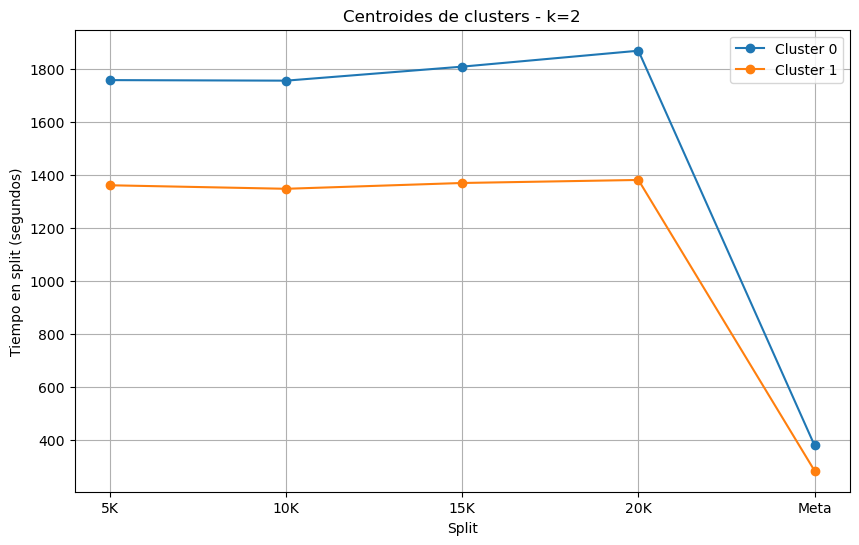

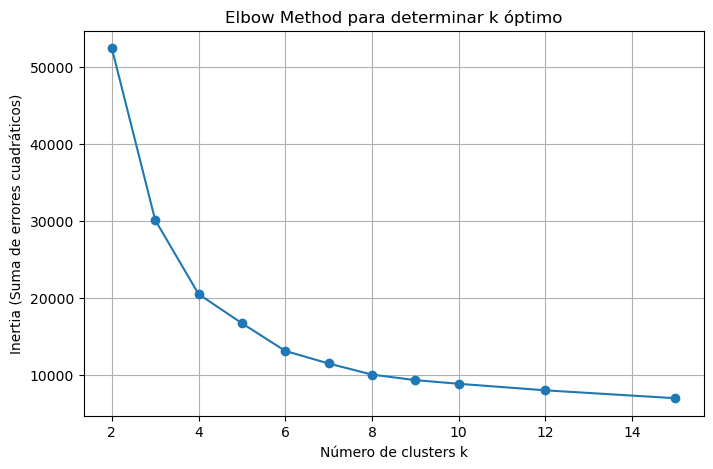

In [ ]:
df_wide_clean, centroid_df, best_k, inertia_values = cluster_splits_KNN(df_wide, split_cols, k_values=[2,3,4,5,6,7,8,9,10,12,15], iqr_multiplier=3, random_state=42)

### PCA y TSNE y UMAP

#### PCA

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

def plot_pca_analysis(df_wide, split_cols):
    """
    Realiza PCA sobre los splits y genera gráficos por:
    - Género
    - Grupo de edad
    - Club
    - Grupo de tiempo total (cuantiles)
    - Ritmo (variable continua)
    """

    X = df_wide[split_cols].values

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_scaled)

    explained_variance = pca.explained_variance_ratio_
    print(f"Varianza explicada por PCA 1: {explained_variance[0]:.4f} ({explained_variance[0]*100:.2f}%)")
    print(f"Varianza explicada por PCA 2: {explained_variance[1]:.4f} ({explained_variance[1]*100:.2f}%)")
    print(f"Varianza acumulada 2 componentes: {explained_variance.sum():.4f} ({explained_variance.sum()*100:.2f}%)")

    df_plot = df_wide.copy()
    df_plot["PCA1"] = X_pca[:, 0]
    df_plot["PCA2"] = X_pca[:, 1]

    plt.figure(figsize=(8,6))
    for g in df_plot["gender"].unique():
        subset = df_plot[df_plot["gender"] == g]
        plt.scatter(subset["PCA1"], subset["PCA2"], s=50, alpha=0.6, label=g)

    plt.xlabel("PCA1")
    plt.ylabel("PCA2")
    plt.title("PCA separado por género")
    plt.legend(title="Género")
    plt.grid(True)
    plt.show()

    bins_edad = [0, 20, 30, 40, 50, 60, 100]
    labels_edad = ["<20", "20-29", "30-39", "40-49", "50-59", "60+"]

    df_plot["edad_grupo"] = pd.cut(df_plot["age"], bins=bins_edad, labels=labels_edad)

    plt.figure(figsize=(8,6))
    for g in labels_edad:
        subset = df_plot[df_plot["edad_grupo"] == g]
        if not subset.empty:
            plt.scatter(subset["PCA1"], subset["PCA2"], s=50, alpha=0.6, label=g)

    plt.xlabel("PCA1")
    plt.ylabel("PCA2")
    plt.title("PCA por grupos de edad")
    plt.legend(title="Edad")
    plt.grid(True)
    plt.show()


    top_clubs = df_plot["club"].value_counts().head(6).index
    df_plot["club_reducido"] = df_plot["club"].apply(lambda x: x if x in top_clubs else "Otros")

    plt.figure(figsize=(8,6))
    for c in df_plot["club_reducido"].unique():
        subset = df_plot[df_plot["club_reducido"] == c]
        plt.scatter(subset["PCA1"], subset["PCA2"], s=50, alpha=0.6, label=c)

    plt.xlabel("PCA1")
    plt.ylabel("PCA2")
    plt.title("PCA separado por club (Top 6 + Otros)")
    plt.legend(title="Club")
    plt.grid(True)
    plt.show()


    df_plot["tiempo_total"] = df_plot[split_cols].sum(axis=1)
    percentiles = [0, 0.2, 0.4, 0.6, 0.8, 1.0]
    bin_values = df_plot["tiempo_total"].quantile(percentiles).values
    bin_labels = ["Top 20%", "20-40%", "40-60%", "60-80%", "Bottom 20%"]

    df_plot["grupo_tiempo"] = pd.cut(df_plot["tiempo_total"], bins=bin_values,
                                     labels=bin_labels, include_lowest=True)

    plt.figure(figsize=(8,6))
    for g in bin_labels:
        subset = df_plot[df_plot["grupo_tiempo"] == g]
        if not subset.empty:
            plt.scatter(subset["PCA1"], subset["PCA2"], s=50, alpha=0.6, label=g)

    plt.xlabel("PCA1")
    plt.ylabel("PCA2")
    plt.title("PCA según grupo de tiempo total (bins cuantiles)")
    plt.legend(title="Tiempo")
    plt.grid(True)
    plt.show()

    df_plot["pace"] = 21097.5 / df_plot["tiempo_total"]

    plt.figure(figsize=(8,6))
    sc = plt.scatter(df_plot["PCA1"], df_plot["PCA2"], c=df_plot["pace"], s=50, alpha=0.7, cmap="viridis")
    plt.colorbar(sc, label="Ritmo (m/s)")
    plt.xlabel("PCA1")
    plt.ylabel("PCA2")
    plt.title("PCA coloreado por ritmo (variable continua)")
    plt.grid(True)
    plt.show()

    return df_plot, X_scaled

In [54]:
df_plot.head(5)

athlete_id                               race_id event_id       10K  \
0   1111B6ZY  b228b93e-2a15-4123-baf9-ca0915165c6a    Mitja  1633.132   
1   1118BZ53  b228b93e-2a15-4123-baf9-ca0915165c6a    Mitja  1395.566   
2   111CC3F8  b228b93e-2a15-4123-baf9-ca0915165c6a    Mitja  1863.922   
3   111CZ127  b228b93e-2a15-4123-baf9-ca0915165c6a    Mitja  1112.130   
4   112BYA92  b228b93e-2a15-4123-baf9-ca0915165c6a    Mitja  1472.889   

        15K       20K        5K     Meta  gender        age              club  \
0  1625.279  1625.978  1594.475  325.888     0.0  34.064339     Independiente   
1  1382.856  1401.240  1393.216  287.454     0.0  36.703628     Independiente   
2  1862.845  1855.556  1904.496  381.822     1.0  38.299795     Independiente   
3  1134.049  1177.837  1118.088  258.167     0.0  29.336071  CE ILLES BALEARS   
4  1470.094  1463.164  1521.806  299.681     0.0  48.350445     Independiente   

       PCA1      PCA2 edad_grupo  club_reducido  tiempo_total grupo_tiempo  \
0 -0.029479 -0.240472      30-39  Independiente      6804.752       40-60%   
1 -1.680366 -0.025045      30-39  Independiente      5860.332       20-40%   
2  1.900783 -0.453885      30-39  Independiente      7868.641   Bottom 20%   
3 -3.489777  0.487168      20-29          Otros      4800.271      Top 20%   
4 -1.038037 -0.225623      40-49  Independiente      6227.634       20-40%   

       pace  
0  3.100407  
1  3.600052  
2  2.681213  
3  4.395064  
4  3.387723

Varianza explicada por PCA 1: 0.9199 (91.99%)
Varianza explicada por PCA 2: 0.0496 (4.96%)
Varianza acumulada 2 componentes: 0.9695 (96.95%)


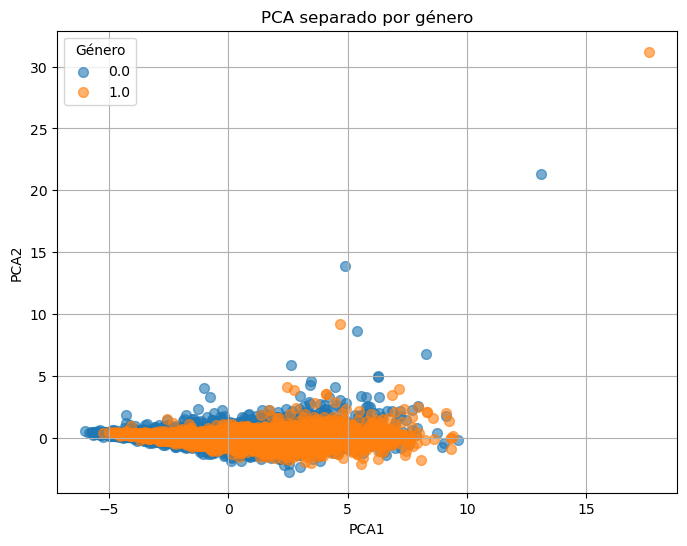

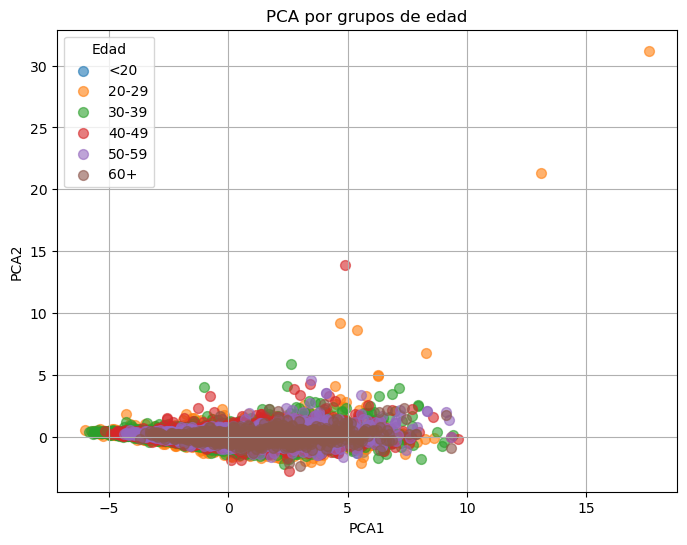

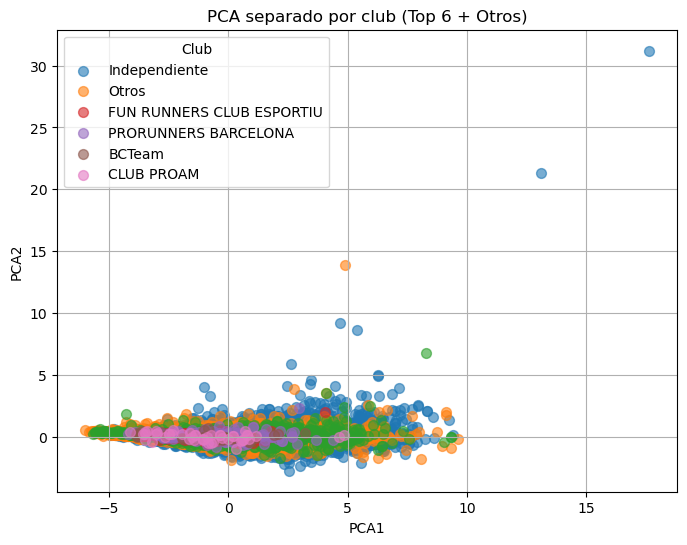

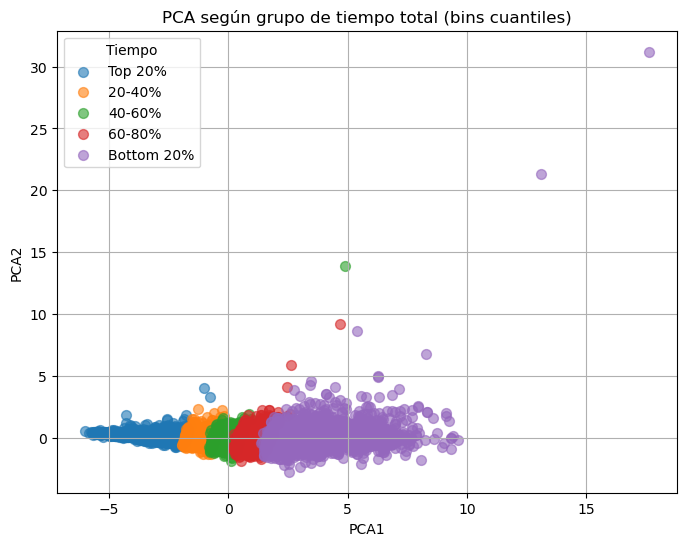

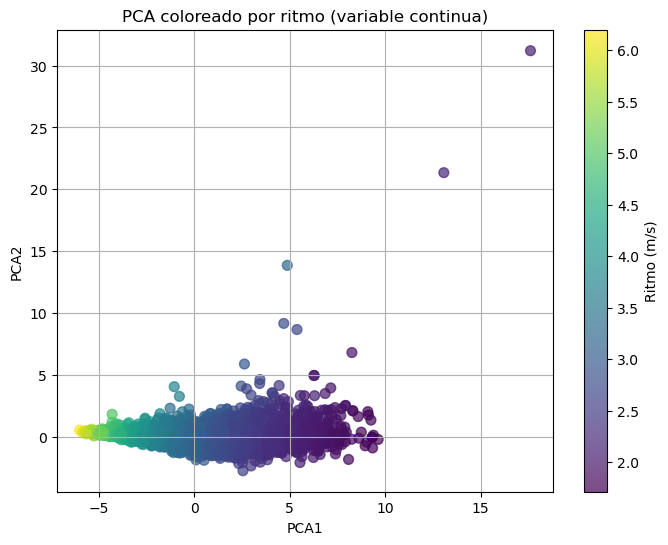

In [ ]:
df_plot, X_scaled = plot_pca_analysis(df_wide, split_cols)

Varianza explicada por PCA 1: 0.9520 (95.20%)
Varianza explicada por PCA 2: 0.0322 (3.22%)
Varianza acumulada 2 componentes: 0.9842 (98.42%)


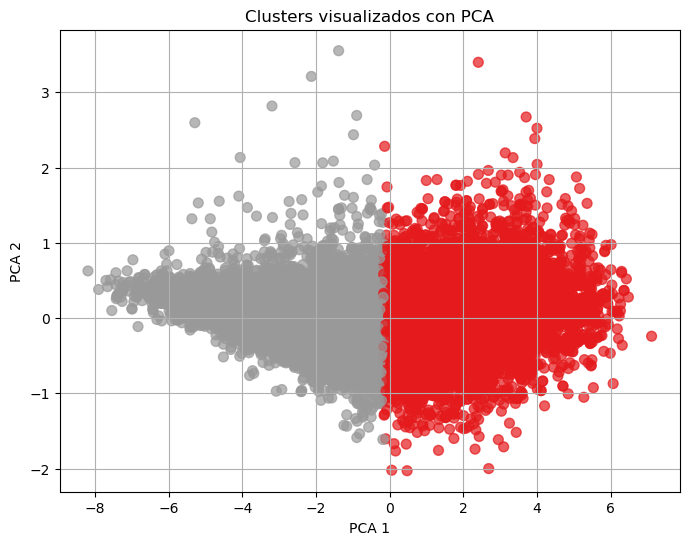

In [26]:
X = df_wide_clean[split_cols].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

explained_variance = pca.explained_variance_ratio_
print(f"Varianza explicada por PCA 1: {explained_variance[0]:.4f} ({explained_variance[0]*100:.2f}%)")
print(f"Varianza explicada por PCA 2: {explained_variance[1]:.4f} ({explained_variance[1]*100:.2f}%)")
print(f"Varianza acumulada 2 componentes: {explained_variance.sum():.4f} ({explained_variance.sum()*100:.2f}%)")

plt.figure(figsize=(8,6))
plt.scatter(X_pca[:,0], X_pca[:,1], c=df_wide_clean['cluster'], cmap='Set1', s=50, alpha=0.7)
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.title('Clusters visualizados con PCA')
plt.grid(True)
plt.show()

In [28]:
loadings = pd.DataFrame(pca.components_.T, index=split_cols, columns=['PCA1', 'PCA2'])
print(loadings)

          PCA1      PCA2
5K    0.442115 -0.585094
10K   0.450830 -0.359371
15K   0.453591 -0.046790
20K   0.449444  0.375844
Meta  0.439934  0.620540


#### TSNE

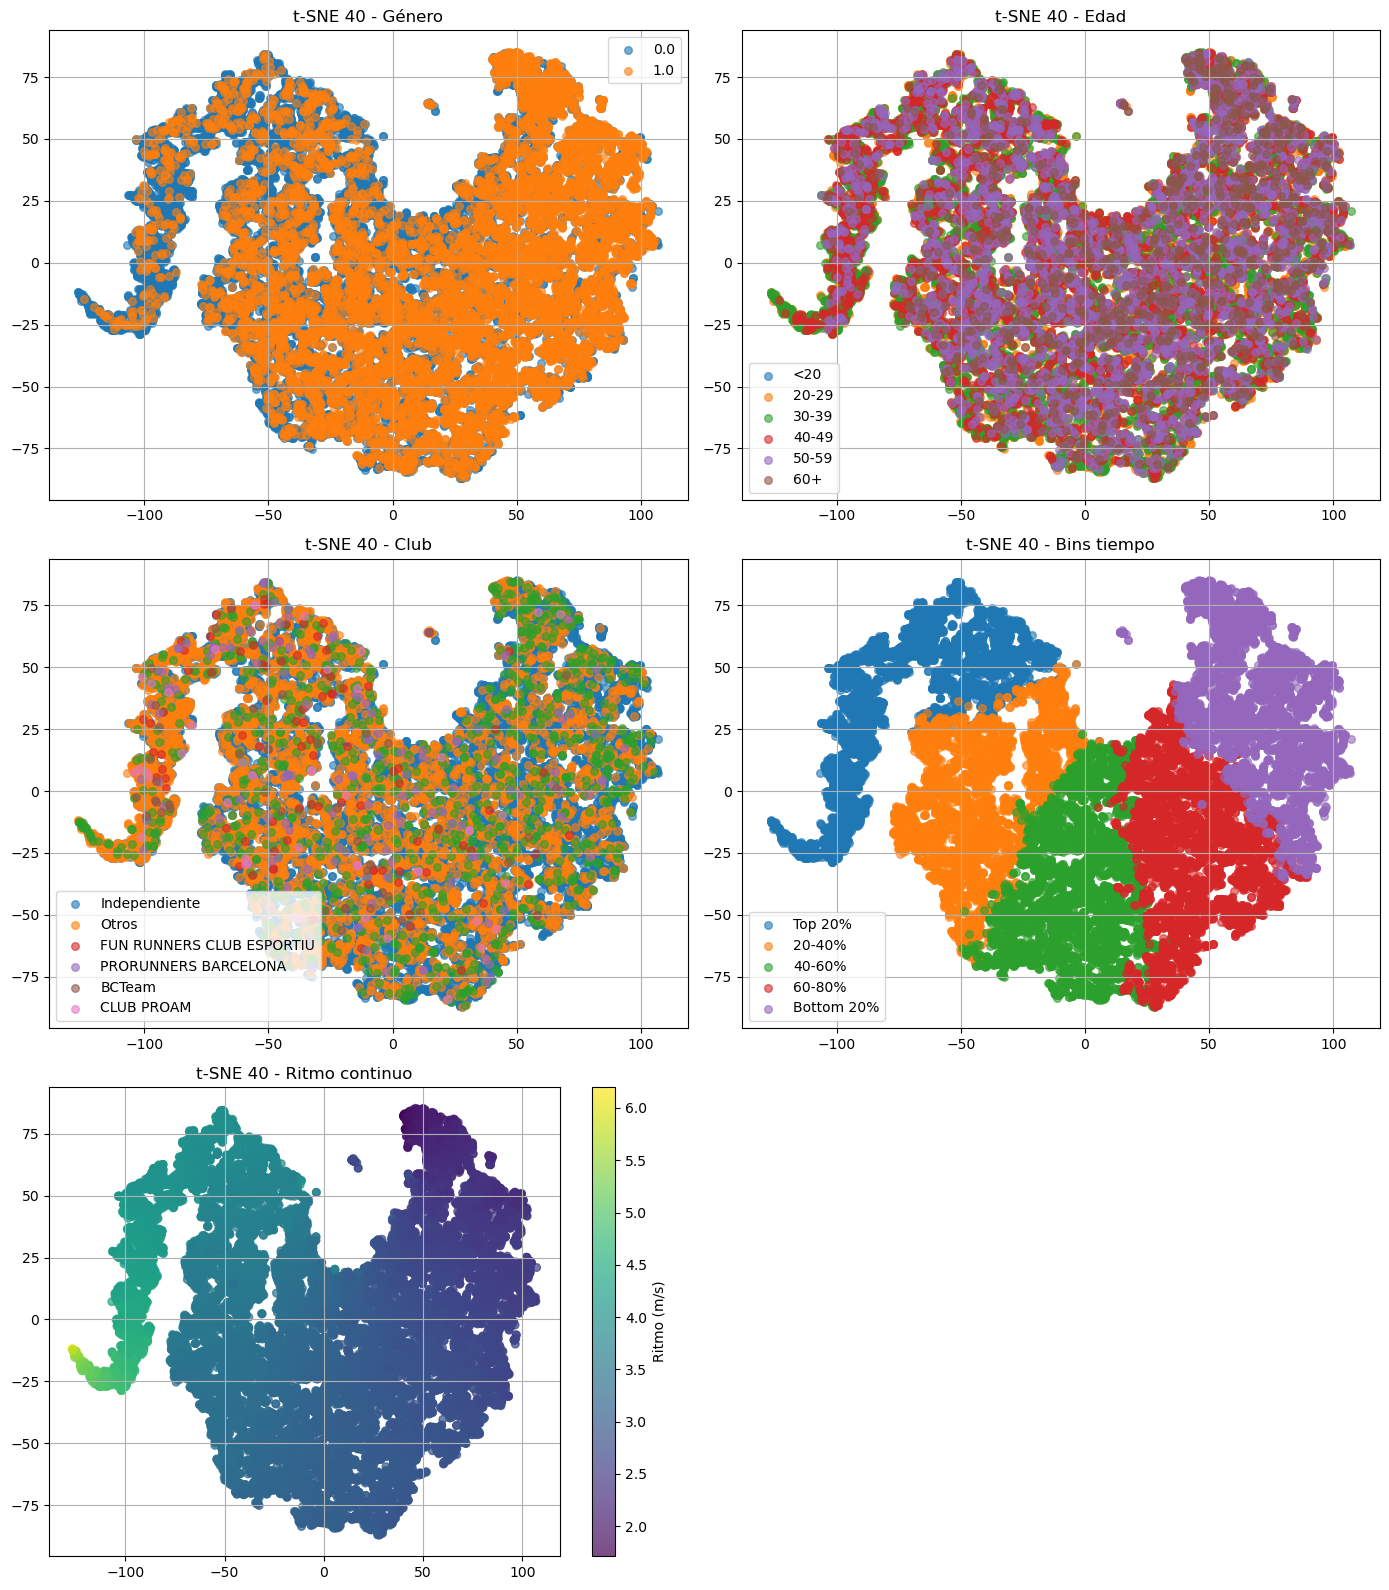

In [ ]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

def plot_tsne_subplots(df, X_scaled, perplexity, title_prefix="t-SNE"):
    tsne = TSNE(n_components=2, random_state=42, perplexity=perplexity, max_iter=1000)
    X_tsne = tsne.fit_transform(X_scaled)
    
    df[f"TSNE1"] = X_tsne[:,0]
    df[f"TSNE2"] = X_tsne[:,1]
    
    fig, axes = plt.subplots(3, 2, figsize=(14, 16))
    axes = axes.flatten()
    
    # 1. Género
    ax = axes[0]
    for g in df["gender"].unique():
        sub = df[df["gender"] == g]
        ax.scatter(sub["TSNE1"], sub["TSNE2"], s=30, alpha=0.6, label=g)
    ax.set_title(f"{title_prefix} {perplexity} - Género")
    ax.legend()
    ax.grid(True)
    
    # 2. Edad
    ax = axes[1]
    for g in df["edad_grupo"].cat.categories:
        sub = df[df["edad_grupo"] == g]
        if not sub.empty:
            ax.scatter(sub["TSNE1"], sub["TSNE2"], s=30, alpha=0.6, label=g)
    ax.set_title(f"{title_prefix} {perplexity} - Edad")
    ax.legend()
    ax.grid(True)
    
    # 3. Club
    ax = axes[2]
    for c in df["club_reducido"].unique():
        sub = df[df["club_reducido"] == c]
        ax.scatter(sub["TSNE1"], sub["TSNE2"], s=30, alpha=0.6, label=c)
    ax.set_title(f"{title_prefix} {perplexity} - Club")
    ax.legend()
    ax.grid(True)
    
    # 4. Grupo de tiempo
    ax = axes[3]
    for g in df["grupo_tiempo"].cat.categories:
        sub = df[df["grupo_tiempo"] == g]
        if not sub.empty:
            ax.scatter(sub["TSNE1"], sub["TSNE2"], s=30, alpha=0.6, label=g)
    ax.set_title(f"{title_prefix} {perplexity} - Bins tiempo")
    ax.legend()
    ax.grid(True)
    
    # 5. Ritmo continuo
    ax = axes[4]
    sc = ax.scatter(df["TSNE1"], df["TSNE2"], c=df["pace"], s=30, alpha=0.7, cmap="viridis")
    fig.colorbar(sc, ax=ax, label="Ritmo (m/s)")
    ax.set_title(f"{title_prefix} {perplexity} - Ritmo continuo")
    ax.grid(True)
    
    # 6. Clusters
    ax = axes[5]
    if "cluster" in df.columns:
        sc = ax.scatter(df["TSNE1"], df["TSNE2"], c=df["cluster"], s=30, alpha=0.7, cmap="Set1")
        ax.set_title(f"{title_prefix} {perplexity} - Clusters")
        ax.grid(True)
    else:
        ax.axis("off")
    
    plt.tight_layout()
    plt.show()


plot_tsne_subplots(df_plot.copy(), X_scaled, perplexity=40, title_prefix="t-SNE")
#plot_tsne_subplots(df_plot.copy(), X_scaled, perplexity=50, title_prefix="t-SNE")

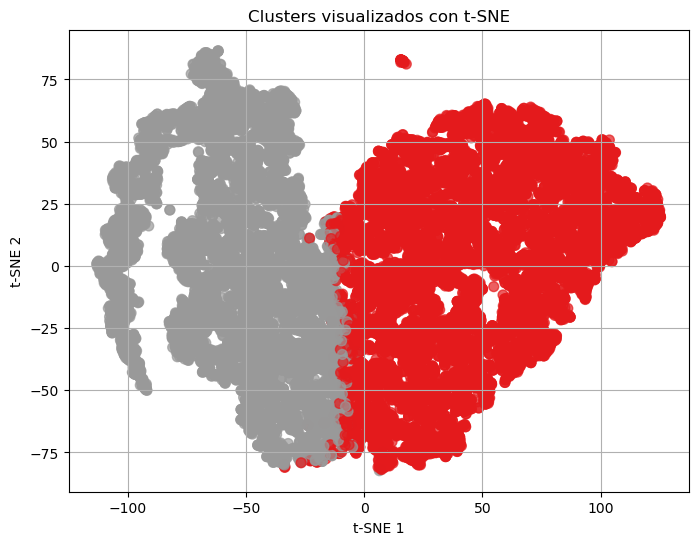

In [ ]:
tsne = TSNE(n_components=2, random_state=42, perplexity=40, max_iter=1000)
X_tsne = tsne.fit_transform(X_scaled)

plt.figure(figsize=(8,6))
plt.scatter(X_tsne[:,0], X_tsne[:,1], c=df_wide_clean['cluster'], cmap='Set1', s=50, alpha=0.7)
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.title('Clusters visualizados con t-SNE')
plt.grid(True)
plt.show()

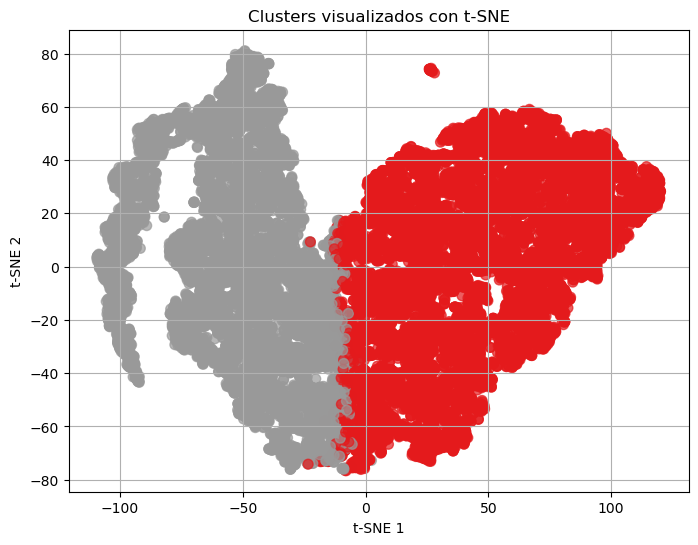

In [ ]:
tsne = TSNE(n_components=2, random_state=42, perplexity=50, max_iter=1000)
X_tsne = tsne.fit_transform(X_scaled)

plt.figure(figsize=(8,6))
plt.scatter(X_tsne[:,0], X_tsne[:,1], c=df_wide_clean['cluster'], cmap='Set1', s=50, alpha=0.7)
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.title('Clusters visualizados con t-SNE')
plt.grid(True)
plt.show()

#### UMAP

### DBSCAN

### Selección de características y escalado

Se seleccionan las columnas de splits que se usarán como características para clustering:

$$
X =
\begin{bmatrix}
x_{1, \text{5K}} & x_{1, \text{10K}} & x_{1, \text{15K}} & x_{1, \text{20K}} & x_{1, \text{Meta}} \\
x_{2, \text{5K}} & x_{2, \text{10K}} & x_{2, \text{15K}} & x_{2, \text{20K}} & x_{2, \text{Meta}} \\
\vdots & \vdots & \vdots & \vdots & \vdots \\
x_{n, \text{5K}} & x_{n, \text{10K}} & x_{n, \text{15K}} & x_{n, \text{20K}} & x_{n, \text{Meta}}
\end{bmatrix}
$$

Cada fila representa un atleta y cada columna un split, manteniendo el orden temporal.  

Se normalizan las columnas para que tengan media 0 y desviación estándar 1:

---

### Curva k-distancia para DBSCAN

Para seleccionar el parámetro $\epsilon$ en DBSCAN, se calcula la distancia al $k$-ésimo vecino para cada punto en el espacio escalado:

$$
\text{distancias}_i = \text{distancia del punto } i \text{ a su } k\text{-ésimo vecino más cercano}
$$

Ordenando estas distancias de menor a mayor y graficando:

$$
\text{distancias}_{\text{ordenadas}} = \text{sort}(\text{distancias}_1, \dots, \text{distancias}_n)
$$

El codo de esta curva indica un valor razonable para $\epsilon$.

---

### DBSCAN

DBSCAN es un algoritmo de clustering basado en densidad que clasifica puntos como:

- **Core points:** puntos con al menos min_samples vecinos dentro de un radio $\epsilon$
- **Border points:** puntos que están dentro del radio $\epsilon$ de un core point pero no son core themselves
- **Outliers (ruido):** puntos que no cumplen ninguna de las condiciones anteriores, etiquetados como $-1$

Matemáticamente:

$$
\text{dbscan\_label}_i =
\begin{cases}
C_m & \text{si el punto } i \text{ pertenece al cluster } m \\
-1 & \text{si es outlier}
\end{cases}
$$

donde $C_m$ son los clusters detectados.

---

### Visualización con PCA

Para visualizar los clusters detectados por DBSCAN en 2D, se realiza un PCA:

$$
X_{\text{PCA}} = X_{\text{scaled}} \cdot W
$$

donde $W$ contiene los vectores propios asociados a las dos mayores componentes principales. Cada punto se grafica usando sus coordenadas $(X_{\text{PCA},1}, X_{\text{PCA},2})$ y se colorea según la etiqueta de DBSCAN, con $-1$ representando outliers.

---

**Resumen conceptual:**

- `X_scaled` se obtiene escalando los splits para mantener proporcionalidad.  
- La curva k-distancia permite seleccionar un $\epsilon$ adecuado.  
- DBSCAN identifica clusters densos y outliers.  
- PCA reduce la dimensionalidad a 2D para visualización, manteniendo la estructura de los clusters.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors


def plot_k_distance_curve(df_wide_clean, ordered_splits, k=10, figsize=(8, 5)):
    """
    Calcula y grafica la curva de distancias al k-ésimo vecino
    para ayudar a seleccionar eps en DBSCAN.

    Parámetros
    ----------
    df_wide_clean : DataFrame
        DataFrame con los splits limpios (sin outliers y transformados).
    ordered_splits : list
        Lista ordenada de splits a usar como features.
    k : int, opcional (default=10)
        Número de vecinos para la curva k-distance.
    figsize : tuple, opcional
        Tamaño de la figura del plot.

    Returns
    -------
    distances_sorted : np.array
        Vector con las distancias ordenadas al k-ésimo vecino.
    X_scaled : np.array
        Matriz de features escalada.
    """
    
    X = df_wide_clean[ordered_splits].values

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    neighbors = NearestNeighbors(n_neighbors=k)
    neighbors_fit = neighbors.fit(X_scaled)
    distances, indices = neighbors_fit.kneighbors(X_scaled)

    distances_sorted = np.sort(distances[:, k-1])

    plt.figure(figsize=figsize)
    plt.plot(distances_sorted)
    plt.xlabel("Puntos ordenados")
    plt.ylabel(f"Distancia al {k}-ésimo vecino")
    plt.title("Curva k-distancia para elegir eps")
    plt.grid(True)
    plt.show()

    return distances_sorted, X_scaled

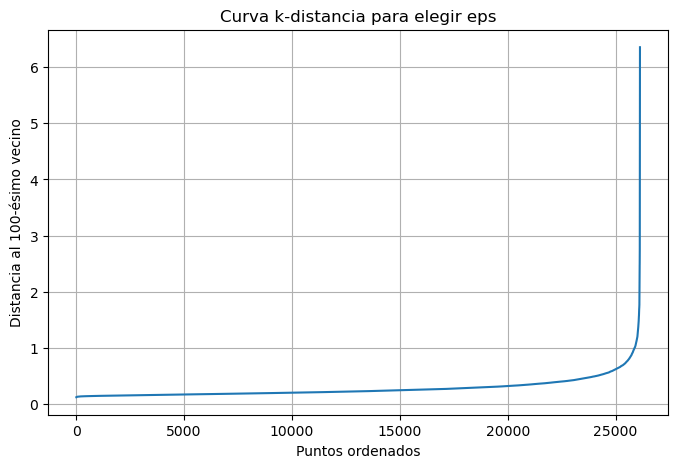

In [66]:
distances_sorted, X_scaled = plot_k_distance_curve(
    df_wide_clean, split_cols, k=100
)

In [67]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA


def dbscan_clustering(df_wide_clean, X_scaled, eps=0.8, min_samples=100, figsize=(8, 6)):
    """
    Ejecuta clustering DBSCAN sobre X_scaled, asigna etiquetas al dataframe
    y grafica el resultado usando PCA (2D).

    Parámetros
    ----------
    df_wide_clean : DataFrame
        DataFrame con los datos limpios donde se añadirá la columna dbscan_label.
    X_scaled : array
        Matriz de características escalada (salida de la función k-distance).
    eps : float, opcional
        Radio máximo para considerar vecinos (parámetro clave de DBSCAN).
    min_samples : int, opcional
        Mínimo de puntos requeridos para formar un cluster.
    figsize : tuple, opcional
        Tamaño de la figura del plot.

    Returns
    -------
    df_out : DataFrame
        DataFrame con cluster asignado en 'dbscan_label'.
    n_clusters : int
        Número de clusters detectados (excluyendo outliers).
    n_outliers : int
        Número de puntos marcados como -1 (outliers).
    pca_components : array
        Coordenadas PCA transformadas (2D).
    """

    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    dbscan_labels = dbscan.fit_predict(X_scaled)

    df_out = df_wide_clean.copy()
    df_out["dbscan_label"] = dbscan_labels

    n_clusters = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
    n_outliers = list(dbscan_labels).count(-1)

    print(f"Número de clusters detectados: {n_clusters}")
    print(f"Número de outliers: {n_outliers}")

    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_scaled)

    plt.figure(figsize=figsize)
    plt.scatter(X_pca[:, 0], X_pca[:, 1], c=dbscan_labels, cmap="tab20", s=50)
    plt.xlabel("PCA 1")
    plt.ylabel("PCA 2")
    plt.title(f"Clusters detectados por DBSCAN (eps={eps}, min_samples={min_samples})")
    plt.colorbar(label="Etiqueta de cluster (−1 = outlier)")
    plt.grid(True)
    plt.show()

    return df_out, n_clusters, n_outliers, X_pca

Número de clusters detectados: 1
Número de outliers: 102


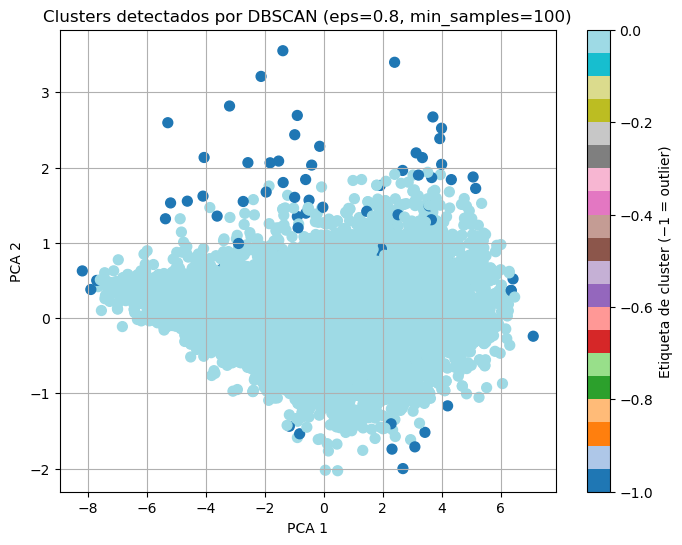

In [68]:
df_dbscan, n_clusters, n_outliers, X_pca = dbscan_clustering(
    df_wide_clean,
    X_scaled,
    eps=0.8,
    min_samples=100
)

In [ ]:
def analizar_outliers_dbscan(df, ordered_splits, label_col='dbscan_label'):
    """
    Separa outliers e inliers según DBSCAN y genera estadísticas + boxplots comparativos.

    Parámetros:
        df : DataFrame con datos limpios y columna dbscan_label
        ordered_splits : lista de columnas de splits en orden
        label_col : nombre de columna donde DBSCAN guardó las etiquetas (default: 'dbscan_label')
    """

    outliers = df[df[label_col] == -1]
    inliers = df[df[label_col] != -1]

    print(f"Número de outliers: {len(outliers)}")
    print(f"Número de puntos en clusters: {len(inliers)}\n")

    print("---- Estadísticas de los puntos en clusters ----")
    print(inliers[ordered_splits].describe())
    print("\n---- Estadísticas de los outliers ----")
    print(outliers[ordered_splits].describe())

    plt.figure(figsize=(10,6))

    plt.boxplot(
        [inliers[split] for split in ordered_splits],
        positions=np.arange(len(ordered_splits))*2 - 0.4,
        widths=0.6
    )

    plt.boxplot(
        [outliers[split] for split in ordered_splits],
        positions=np.arange(len(ordered_splits))*2 + 0.4,
        widths=0.6
    )

    plt.xticks(np.arange(len(ordered_splits))*2, ordered_splits)

    plt.ylabel("Tiempo en split (segundos)")
    plt.title("Comparación entre puntos en clusters (izquierda) y outliers (derecha)")
    plt.grid(True)
    plt.show()

    return inliers, outliers

Número de outliers: 102
Número de puntos en clusters: 26029

---- Estadísticas de los puntos en clusters ----
                 5K           10K           15K           20K          Meta
count  26029.000000  26029.000000  26029.000000  26029.000000  26029.000000
mean       7.357090      7.351528      7.375146      7.396746      5.806572
std        0.165747      0.170598      0.179989      0.195600      0.190218
min        6.737797      6.730806      6.758764      6.760400      5.156143
25%        7.254990      7.246739      7.261801      7.269724      5.678646
50%        7.375340      7.363387      7.381792      7.395486      5.807067
75%        7.470532      7.463598      7.490215      7.524170      5.934013
max        7.897303      7.913763      7.969924      8.026041      6.443457

---- Estadísticas de los outliers ----
               5K         10K         15K         20K        Meta
count  102.000000  102.000000  102.000000  102.000000  102.000000
mean     7.297911    7.364040    7

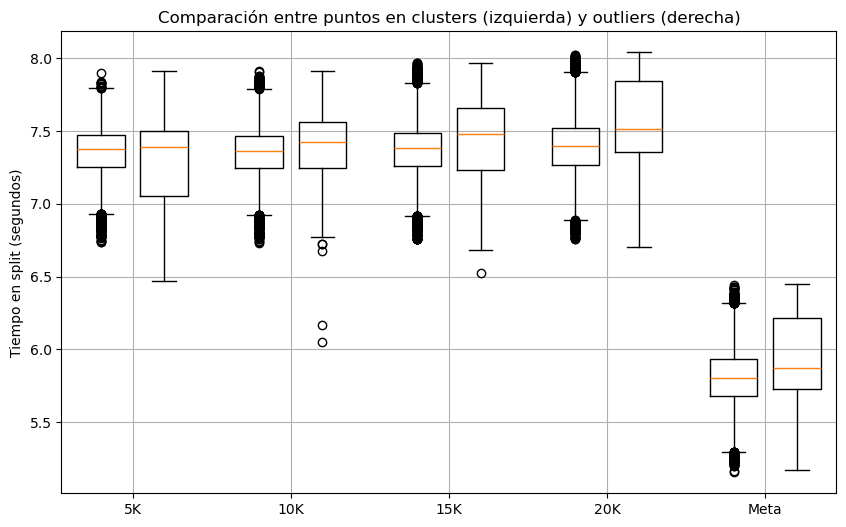

In [70]:
inliers, outliers = analizar_outliers_dbscan(df_dbscan, split_cols)

### pruebas

C:\Users\mario\AppData\Local\Temp\ipykernel_16712\512197020.py:41: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_wide_ac.groupby('grupo_tiempo')
C:\Users\mario\AppData\Local\Temp\ipykernel_16712\512197020.py:42: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(min(tamaño_muestra, len(x))))


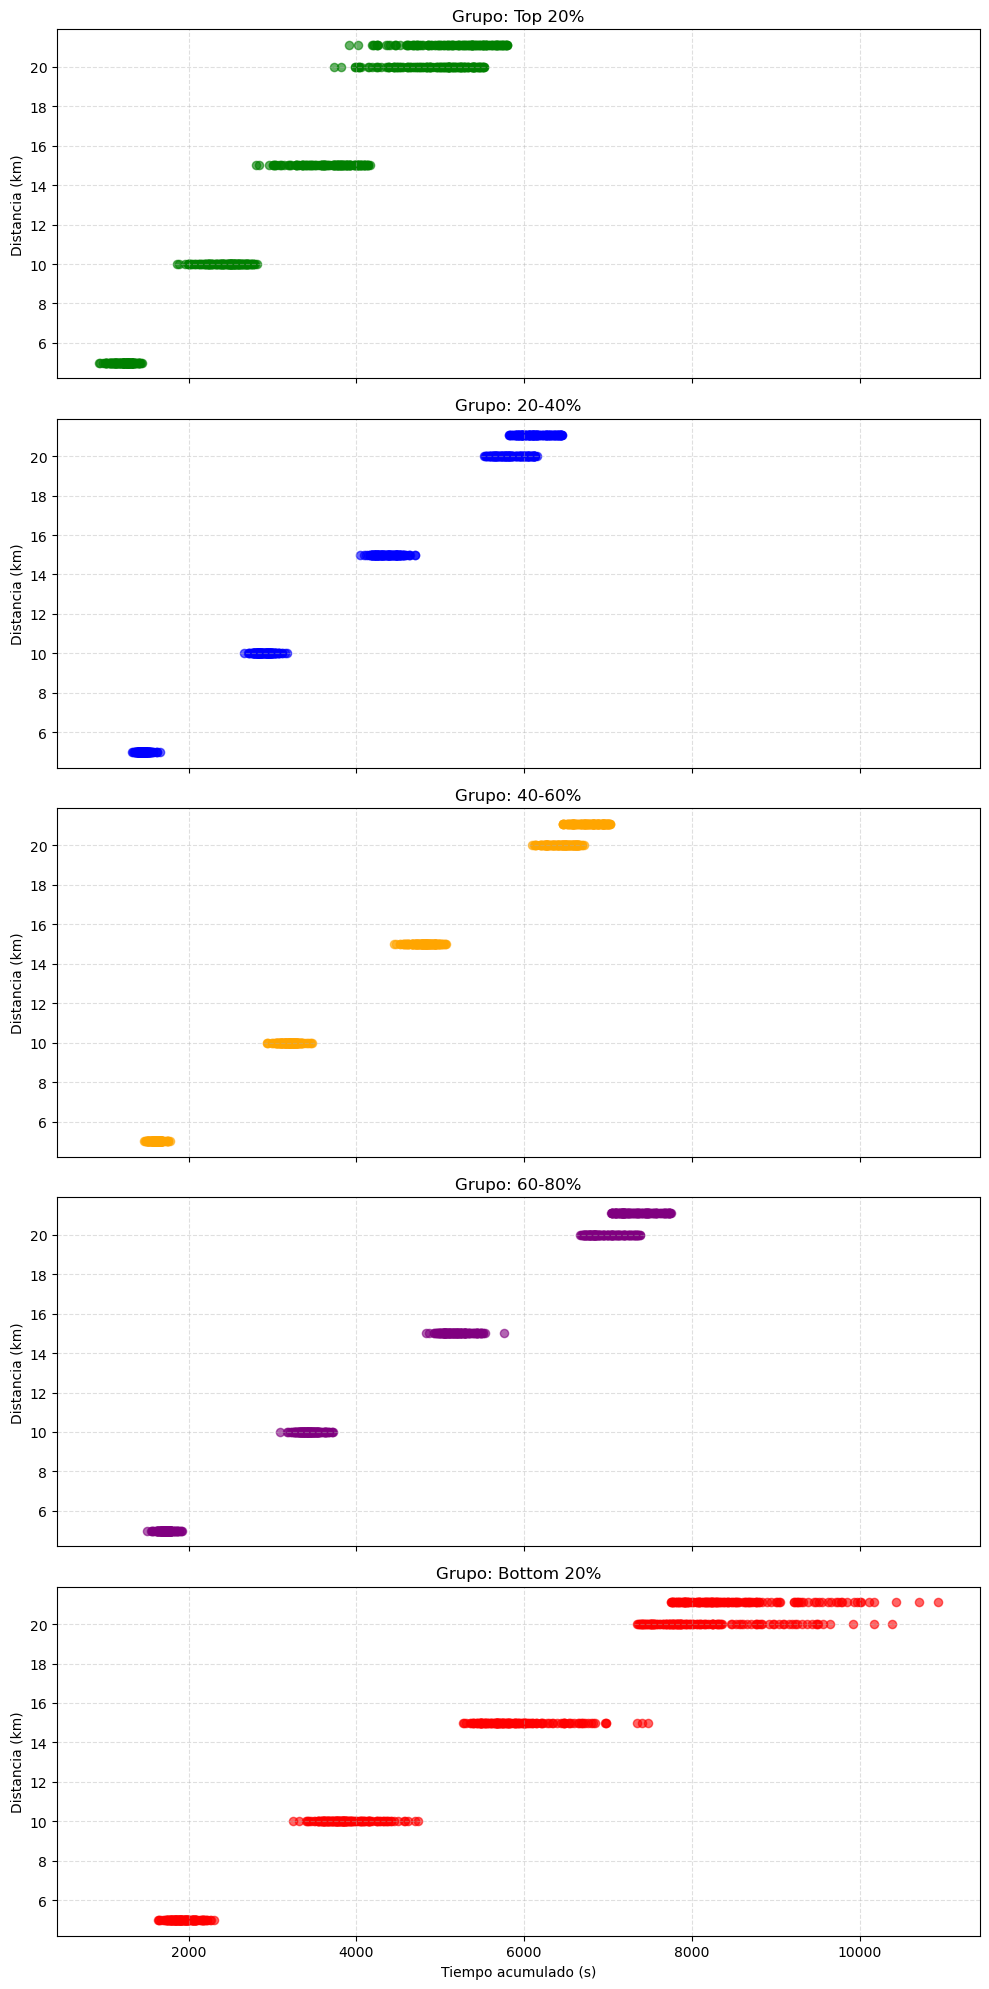

In [27]:
splits = ['5K', '10K', '15K', '20K', 'Meta']
distancias = [5, 10, 15, 20, 21.097]

df_wide_ac = df_wide.copy()
df_wide_ac[splits] = df_wide[splits].cumsum(axis=1)

df_wide_ac['tiempo_total'] = df_wide_ac['Meta']

percentiles = [0, 0.2, 0.4, 0.6, 0.8, 1.0]
bins = df_wide_ac['tiempo_total'].quantile(percentiles).values
labels = ['Top 20%', '20-40%', '40-60%', '60-80%', 'Bottom 20%']

df_wide_ac['grupo_tiempo'] = pd.cut(
    df_wide_ac['tiempo_total'],
    bins=bins,
    labels=labels,
    include_lowest=True
)

tamaño_muestra = 150

muestras = (
    df_wide_ac.groupby('grupo_tiempo')
    .apply(lambda x: x.sample(min(tamaño_muestra, len(x))))
    .reset_index(drop=True)
)

splits_ac = splits  

colores_grupo = {
    'Top 20%': 'green',
    '20-40%': 'blue',
    '40-60%': 'orange',
    '60-80%': 'purple',
    'Bottom 20%': 'red'
}

grupos = muestras['grupo_tiempo'].unique()

fig, axes = plt.subplots(len(grupos), 1, figsize=(10, 4 * len(grupos)), sharex=True)

for ax, grupo in zip(axes, grupos):

    df_grupo = muestras[muestras['grupo_tiempo'] == grupo]

    for idx, row in df_grupo.iterrows():
        tiempos_acumulados = [row[s] for s in splits_ac]  

        ax.scatter(
            tiempos_acumulados,
            distancias,
            s=35,
            color=colores_grupo[grupo],
            alpha=0.6
        )

    ax.set_title(f'Grupo: {grupo}', fontsize=12)
    ax.set_ylabel('Distancia (km)')
    ax.grid(True, linestyle='--', alpha=0.4)

axes[-1].set_xlabel('Tiempo acumulado (s)')
plt.tight_layout()
plt.show()

### pruebas

k=2, BIC=27927.33
k=3, BIC=10259.87
k=4, BIC=3884.53
k=5, BIC=1713.98
k=6, BIC=1829.56
k=7, BIC=1156.16
k=8, BIC=1137.90
k=9, BIC=698.47
k=10, BIC=248.29
k=12, BIC=689.12
k=15, BIC=358.21

Mejor k según BIC: 10


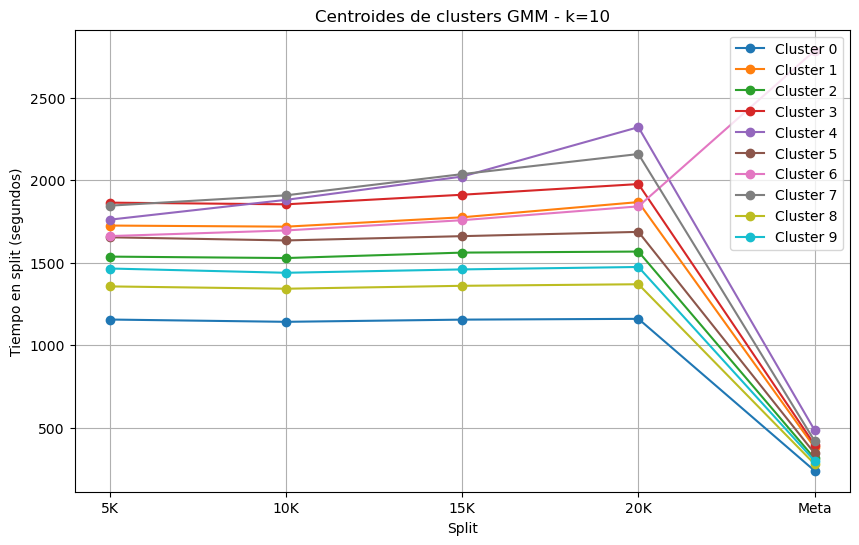

In [37]:
from sklearn.mixture import GaussianMixture
import numpy as np

k_values = [2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 15]
lowest_bic = np.inf
best_gmm = None
bic_scores = []

for k in k_values:
    gmm = GaussianMixture(n_components=k, covariance_type='full', random_state=42)
    gmm.fit(X_scaled)
    bic = gmm.bic(X_scaled)
    bic_scores.append(bic)
    print(f"k={k}, BIC={bic:.2f}")
    
    if bic < lowest_bic:
        lowest_bic = bic
        best_gmm = gmm

print(f"\nMejor k según BIC: {best_gmm.n_components}")

labels_gmm = best_gmm.predict(X_scaled)
df_wide['cluster_gmm'] = labels_gmm

probs_gmm = best_gmm.predict_proba(X_scaled)
centroids_gmm = scaler.inverse_transform(best_gmm.means_)

import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
for i, centroid in enumerate(centroids_gmm):
    plt.plot(split_cols, centroid, marker='o', label=f'Cluster {i}')
plt.xlabel("Split")
plt.ylabel("Tiempo en split (segundos)")
plt.title(f"Centroides de clusters GMM - k={best_gmm.n_components}")
plt.legend()
plt.grid(True)
plt.show()

Bandwidth estimado: 1.1979
Número de clusters encontrados: 49


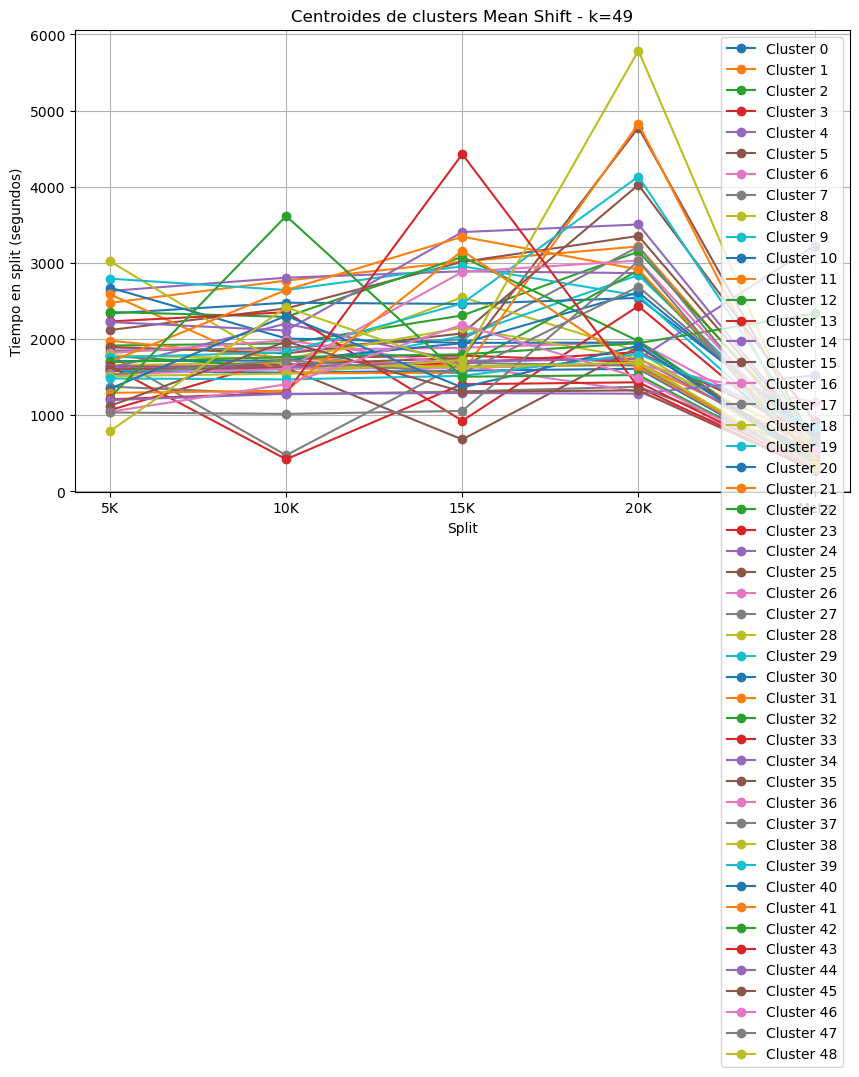

In [38]:
from sklearn.cluster import MeanShift, estimate_bandwidth
import matplotlib.pyplot as plt

bandwidth = estimate_bandwidth(X_scaled, quantile=0.2, n_samples=5000)
print(f"Bandwidth estimado: {bandwidth:.4f}")

ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms.fit(X_scaled)

labels_ms = ms.labels_
cluster_centers = ms.cluster_centers_
n_clusters_ = len(np.unique(labels_ms))
print(f"Número de clusters encontrados: {n_clusters_}")

df_wide['cluster_meanshift'] = labels_ms

centroids_ms = scaler.inverse_transform(cluster_centers)

plt.figure(figsize=(10,6))
for i, centroid in enumerate(centroids_ms):
    plt.plot(split_cols, centroid, marker='o', label=f'Cluster {i}')
plt.xlabel("Split")
plt.ylabel("Tiempo en split (segundos)")
plt.title(f"Centroides de clusters Mean Shift - k={n_clusters_}")
plt.legend()
plt.grid(True)
plt.show()